##### Copyright 2021 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Retraining an Image Classifier


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tf2_image_retraining"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/hub/tutorials/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/hub/tutorials/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/image/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

## Introduction

Image classification models have millions of parameters. Training them from
scratch requires a lot of labeled training data and a lot of computing power. Transfer learning is a technique that shortcuts much of this by taking a piece of a model that has already been trained on a related task and reusing it in a new model.

This Colab demonstrates how to build a Keras model for classifying five species of flowers by using a pre-trained TF2 SavedModel from TensorFlow Hub for image feature extraction, trained on the much larger and more general ImageNet dataset. Optionally, the feature extractor can be trained ("fine-tuned") alongside the newly added classifier.

### Looking for a tool instead?

This is a TensorFlow coding tutorial. If you want a tool that just builds the TensorFlow or TFLite model for, take a look at the [make_image_classifier](https://github.com/tensorflow/hub/tree/master/tensorflow_hub/tools/make_image_classifier) command-line tool that gets [installed](https://www.tensorflow.org/hub/installation) by the PIP package `tensorflow-hub[make_image_classifier]`, or at [this](https://colab.sandbox.google.com/github/tensorflow/examples/blob/master/tensorflow_examples/lite/model_maker/demo/image_classification.ipynb) TFLite colab.


## Setup

In [2]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

2023-12-07 12:22:28.469477: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 12:22:28.469529: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 12:22:28.471019: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TF version: 2.15.0
Hub version: 0.15.0
GPU is NOT AVAILABLE


2023-12-07 12:22:30.732560: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


## Select the TF2 SavedModel module to use

For starters, use [https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4). The same URL can be used in code to identify the SavedModel and in your browser to show its documentation. (Note that models in TF1 Hub format won't work here.)

You can find more TF2 models that generate image feature vectors [here](https://tfhub.dev/s?module-type=image-feature-vector&tf-version=tf2).

There are multiple possible models to try. All you need to do is select a different one on the cell below and follow up with the notebook.

In [3]:
#@title

model_name = "efficientnetv2-xl-21k" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300, 
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 16#@param {type:"integer"}

Selected model: efficientnetv2-xl-21k : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2
Input size (512, 512)


## Set up the Flowers dataset

Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

In [4]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

     8192/228813984 [..............................] - ETA: 0s

 12156928/228813984 [>.............................] - ETA: 0s

 16785408/228813984 [=>............................] - ETA: 1s

 28909568/228813984 [==>...........................] - ETA: 1s

 41189376/228813984 [====>.........................] - ETA: 1s

 52109312/228813984 [=====>........................] - ETA: 0s

 58728448/228813984 [======>.......................] - ETA: 1s

 72654848/228813984 [========>.....................] - ETA: 0s

 86548480/228813984 [==========>...................] - ETA: 0s

100671488/228813984 [============>.................] - ETA: 0s

113778688/228813984 [=============>................] - ETA: 0s

126279680/228813984 [===============>..............] - ETA: 0s

134225920/228813984 [================>.............] - ETA: 0s

147857408/228813984 [==================>...........] - ETA: 0s

162168832/228813984 [====================>.........] - ETA: 0s

167780352/228813984 [====================>.........] - ETA: 0s

181657600/228813984 [======================>.......] - ETA: 0s

194936832/228813984 [========================>.....] - ETA: 0s

201711616/228813984 [=========================>....] - ETA: 0s

215834624/228813984 [===========================>..] - ETA: 0s

228813984/228813984 [==============================] - 1s 0us/step


In [5]:
def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.20,
      subset=subset,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 3670 files belonging to 5 classes.


Using 2936 files for training.


Found 3670 files belonging to 5 classes.


Using 734 files for validation.


## Defining the model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [6]:
do_fine_tuning = False #@param {type:"boolean"}

In [7]:
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2


Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 keras_layer (KerasLayer)    (None, 1280)              207615832 


 dropout (Dropout)           (None, 1280)              0         


 dense (Dense)               (None, 5)                 6405      


Total params: 207622237 (792.02 MB)


Trainable params: 6405 (25.02 KB)


Non-trainable params: 207615832 (791.99 MB)


_________________________________________________________________


## Training the model

In [8]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [9]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/5


  1/183 [..............................] - ETA: 1:53:16 - loss: 2.3505 - accuracy: 0.1875

  2/183 [..............................] - ETA: 21:18 - loss: 2.1442 - accuracy: 0.1875  

  3/183 [..............................] - ETA: 21:12 - loss: 1.8745 - accuracy: 0.3333

  4/183 [..............................] - ETA: 21:07 - loss: 1.7107 - accuracy: 0.4219

  5/183 [..............................] - ETA: 21:00 - loss: 1.6592 - accuracy: 0.4375

  6/183 [..............................] - ETA: 20:54 - loss: 1.6239 - accuracy: 0.4271

  7/183 [>.............................] - ETA: 20:48 - loss: 1.5472 - accuracy: 0.4643

  8/183 [>.............................] - ETA: 20:42 - loss: 1.4991 - accuracy: 0.5000

  9/183 [>.............................] - ETA: 20:35 - loss: 1.4511 - accuracy: 0.5347

 10/183 [>.............................] - ETA: 20:28 - loss: 1.3937 - accuracy: 0.5688

 11/183 [>.............................] - ETA: 20:21 - loss: 1.3750 - accuracy: 0.5966

 12/183 [>.............................] - ETA: 20:14 - loss: 1.3221 - accuracy: 0.6302

 13/183 [=>............................] - ETA: 20:08 - loss: 1.2818 - accuracy: 0.6490

 14/183 [=>............................] - ETA: 20:00 - loss: 1.2985 - accuracy: 0.6607

 15/183 [=>............................] - ETA: 19:53 - loss: 1.2762 - accuracy: 0.6792

 16/183 [=>............................] - ETA: 19:45 - loss: 1.2519 - accuracy: 0.6992

 17/183 [=>............................] - ETA: 19:38 - loss: 1.2269 - accuracy: 0.7096

 18/183 [=>............................] - ETA: 19:31 - loss: 1.2054 - accuracy: 0.7188

 19/183 [==>...........................] - ETA: 19:23 - loss: 1.2074 - accuracy: 0.7237

 20/183 [==>...........................] - ETA: 19:16 - loss: 1.2097 - accuracy: 0.7312

 21/183 [==>...........................] - ETA: 19:09 - loss: 1.1976 - accuracy: 0.7411

 22/183 [==>...........................] - ETA: 19:03 - loss: 1.1814 - accuracy: 0.7528

 23/183 [==>...........................] - ETA: 18:56 - loss: 1.1968 - accuracy: 0.7554

 24/183 [==>...........................] - ETA: 18:49 - loss: 1.1833 - accuracy: 0.7604

 25/183 [===>..........................] - ETA: 18:43 - loss: 1.1869 - accuracy: 0.7675

 26/183 [===>..........................] - ETA: 18:36 - loss: 1.1806 - accuracy: 0.7716

 27/183 [===>..........................] - ETA: 18:29 - loss: 1.1808 - accuracy: 0.7778

 28/183 [===>..........................] - ETA: 18:22 - loss: 1.1700 - accuracy: 0.7857

 29/183 [===>..........................] - ETA: 18:15 - loss: 1.1559 - accuracy: 0.7931

 30/183 [===>..........................] - ETA: 18:08 - loss: 1.1448 - accuracy: 0.8000

 31/183 [====>.........................] - ETA: 18:01 - loss: 1.1370 - accuracy: 0.8065

 32/183 [====>.........................] - ETA: 17:54 - loss: 1.1310 - accuracy: 0.8125

 33/183 [====>.........................] - ETA: 17:48 - loss: 1.1258 - accuracy: 0.8182

 34/183 [====>.........................] - ETA: 17:41 - loss: 1.1220 - accuracy: 0.8217

 35/183 [====>.........................] - ETA: 17:34 - loss: 1.1146 - accuracy: 0.8250

 36/183 [====>.........................] - ETA: 17:26 - loss: 1.1046 - accuracy: 0.8299

 37/183 [=====>........................] - ETA: 17:19 - loss: 1.1022 - accuracy: 0.8311

 38/183 [=====>........................] - ETA: 17:12 - loss: 1.0980 - accuracy: 0.8322

 39/183 [=====>........................] - ETA: 17:02 - loss: 1.0918 - accuracy: 0.8365

 40/183 [=====>........................] - ETA: 16:55 - loss: 1.0852 - accuracy: 0.8359

 41/183 [=====>........................] - ETA: 16:48 - loss: 1.0769 - accuracy: 0.8399

 42/183 [=====>........................] - ETA: 16:41 - loss: 1.0709 - accuracy: 0.8408

 43/183 [======>.......................] - ETA: 16:33 - loss: 1.0808 - accuracy: 0.8401

 44/183 [======>.......................] - ETA: 16:26 - loss: 1.0710 - accuracy: 0.8438

 45/183 [======>.......................] - ETA: 16:19 - loss: 1.0631 - accuracy: 0.8472

 46/183 [======>.......................] - ETA: 16:12 - loss: 1.0560 - accuracy: 0.8505

 47/183 [======>.......................] - ETA: 16:05 - loss: 1.0537 - accuracy: 0.8511

 48/183 [======>.......................] - ETA: 15:58 - loss: 1.0471 - accuracy: 0.8529

 49/183 [=======>......................] - ETA: 15:51 - loss: 1.0384 - accuracy: 0.8559

 50/183 [=======>......................] - ETA: 15:44 - loss: 1.0323 - accuracy: 0.8575

 51/183 [=======>......................] - ETA: 15:37 - loss: 1.0415 - accuracy: 0.8542

 52/183 [=======>......................] - ETA: 15:29 - loss: 1.0350 - accuracy: 0.8558

 53/183 [=======>......................] - ETA: 15:23 - loss: 1.0300 - accuracy: 0.8550

 54/183 [=======>......................] - ETA: 15:16 - loss: 1.0231 - accuracy: 0.8565

 55/183 [========>.....................] - ETA: 15:09 - loss: 1.0171 - accuracy: 0.8580

 56/183 [========>.....................] - ETA: 15:02 - loss: 1.0137 - accuracy: 0.8594

 57/183 [========>.....................] - ETA: 14:56 - loss: 1.0156 - accuracy: 0.8586

 58/183 [========>.....................] - ETA: 14:49 - loss: 1.0092 - accuracy: 0.8599

 59/183 [========>.....................] - ETA: 14:42 - loss: 1.0112 - accuracy: 0.8581

 60/183 [========>.....................] - ETA: 14:35 - loss: 1.0030 - accuracy: 0.8604

 61/183 [=========>....................] - ETA: 14:28 - loss: 0.9986 - accuracy: 0.8607

 62/183 [=========>....................] - ETA: 14:21 - loss: 0.9991 - accuracy: 0.8589

 63/183 [=========>....................] - ETA: 14:14 - loss: 1.0058 - accuracy: 0.8601

 64/183 [=========>....................] - ETA: 14:07 - loss: 1.0071 - accuracy: 0.8604

 65/183 [=========>....................] - ETA: 14:00 - loss: 1.0012 - accuracy: 0.8625

 66/183 [=========>....................] - ETA: 13:53 - loss: 0.9965 - accuracy: 0.8636

 67/183 [=========>....................] - ETA: 13:46 - loss: 0.9917 - accuracy: 0.8647

 68/183 [==========>...................] - ETA: 13:39 - loss: 0.9866 - accuracy: 0.8658

 69/183 [==========>...................] - ETA: 13:32 - loss: 0.9815 - accuracy: 0.8678

 70/183 [==========>...................] - ETA: 13:25 - loss: 0.9764 - accuracy: 0.8696

 71/183 [==========>...................] - ETA: 13:18 - loss: 0.9712 - accuracy: 0.8706

 72/183 [==========>...................] - ETA: 13:10 - loss: 0.9675 - accuracy: 0.8715

 73/183 [==========>...................] - ETA: 13:03 - loss: 0.9703 - accuracy: 0.8716

 74/183 [===========>..................] - ETA: 12:56 - loss: 0.9683 - accuracy: 0.8725

 75/183 [===========>..................] - ETA: 12:49 - loss: 0.9669 - accuracy: 0.8725

 76/183 [===========>..................] - ETA: 12:42 - loss: 0.9662 - accuracy: 0.8717

 77/183 [===========>..................] - ETA: 12:35 - loss: 0.9636 - accuracy: 0.8718

 78/183 [===========>..................] - ETA: 12:28 - loss: 0.9602 - accuracy: 0.8726

 79/183 [===========>..................] - ETA: 12:22 - loss: 0.9568 - accuracy: 0.8742

 80/183 [============>.................] - ETA: 12:15 - loss: 0.9569 - accuracy: 0.8742

 81/183 [============>.................] - ETA: 12:08 - loss: 0.9537 - accuracy: 0.8758

 82/183 [============>.................] - ETA: 12:01 - loss: 0.9499 - accuracy: 0.8765

 83/183 [============>.................] - ETA: 11:54 - loss: 0.9486 - accuracy: 0.8765

 84/183 [============>.................] - ETA: 11:47 - loss: 0.9450 - accuracy: 0.8780

 85/183 [============>.................] - ETA: 11:40 - loss: 0.9495 - accuracy: 0.8772

 86/183 [=============>................] - ETA: 11:33 - loss: 0.9461 - accuracy: 0.8779

 87/183 [=============>................] - ETA: 11:26 - loss: 0.9440 - accuracy: 0.8786

 88/183 [=============>................] - ETA: 11:19 - loss: 0.9430 - accuracy: 0.8778

 89/183 [=============>................] - ETA: 11:12 - loss: 0.9394 - accuracy: 0.8792

 90/183 [=============>................] - ETA: 11:05 - loss: 0.9400 - accuracy: 0.8778

 91/183 [=============>................] - ETA: 10:58 - loss: 0.9400 - accuracy: 0.8771

 92/183 [==============>...............] - ETA: 10:51 - loss: 0.9408 - accuracy: 0.8764

 93/183 [==============>...............] - ETA: 10:44 - loss: 0.9368 - accuracy: 0.8777

 94/183 [==============>...............] - ETA: 10:37 - loss: 0.9331 - accuracy: 0.8790

 95/183 [==============>...............] - ETA: 10:30 - loss: 0.9332 - accuracy: 0.8783

 96/183 [==============>...............] - ETA: 10:23 - loss: 0.9297 - accuracy: 0.8796

 97/183 [==============>...............] - ETA: 10:16 - loss: 0.9268 - accuracy: 0.8808

 98/183 [===============>..............] - ETA: 10:09 - loss: 0.9257 - accuracy: 0.8814

 99/183 [===============>..............] - ETA: 10:02 - loss: 0.9240 - accuracy: 0.8813

100/183 [===============>..............] - ETA: 9:55 - loss: 0.9224 - accuracy: 0.8813 

101/183 [===============>..............] - ETA: 9:48 - loss: 0.9208 - accuracy: 0.8806

102/183 [===============>..............] - ETA: 9:41 - loss: 0.9178 - accuracy: 0.8811

103/183 [===============>..............] - ETA: 9:34 - loss: 0.9167 - accuracy: 0.8817

104/183 [================>.............] - ETA: 9:27 - loss: 0.9153 - accuracy: 0.8816

105/183 [================>.............] - ETA: 9:20 - loss: 0.9151 - accuracy: 0.8821

106/183 [================>.............] - ETA: 9:13 - loss: 0.9139 - accuracy: 0.8827

107/183 [================>.............] - ETA: 9:06 - loss: 0.9113 - accuracy: 0.8838

108/183 [================>.............] - ETA: 8:59 - loss: 0.9090 - accuracy: 0.8843

109/183 [================>.............] - ETA: 8:52 - loss: 0.9068 - accuracy: 0.8853

110/183 [=================>............] - ETA: 8:45 - loss: 0.9054 - accuracy: 0.8852

111/183 [=================>............] - ETA: 8:38 - loss: 0.9029 - accuracy: 0.8863

112/183 [=================>............] - ETA: 8:30 - loss: 0.9008 - accuracy: 0.8867

113/183 [=================>............] - ETA: 8:23 - loss: 0.8992 - accuracy: 0.8872

114/183 [=================>............] - ETA: 8:16 - loss: 0.8967 - accuracy: 0.8882

115/183 [=================>............] - ETA: 8:09 - loss: 0.8953 - accuracy: 0.8880

116/183 [==================>...........] - ETA: 8:02 - loss: 0.8928 - accuracy: 0.8885

117/183 [==================>...........] - ETA: 7:55 - loss: 0.8904 - accuracy: 0.8889

118/183 [==================>...........] - ETA: 7:48 - loss: 0.8881 - accuracy: 0.8893

119/183 [==================>...........] - ETA: 7:41 - loss: 0.8856 - accuracy: 0.8902

120/183 [==================>...........] - ETA: 7:34 - loss: 0.8835 - accuracy: 0.8911

121/183 [==================>...........] - ETA: 7:27 - loss: 0.8816 - accuracy: 0.8915

122/183 [===================>..........] - ETA: 7:20 - loss: 0.8809 - accuracy: 0.8914

123/183 [===================>..........] - ETA: 7:13 - loss: 0.8782 - accuracy: 0.8923

124/183 [===================>..........] - ETA: 7:06 - loss: 0.8761 - accuracy: 0.8926

125/183 [===================>..........] - ETA: 6:58 - loss: 0.8735 - accuracy: 0.8935

126/183 [===================>..........] - ETA: 6:51 - loss: 0.8723 - accuracy: 0.8934

127/183 [===================>..........] - ETA: 6:44 - loss: 0.8707 - accuracy: 0.8937

128/183 [===================>..........] - ETA: 6:37 - loss: 0.8688 - accuracy: 0.8940

129/183 [====================>.........] - ETA: 6:30 - loss: 0.8659 - accuracy: 0.8949

130/183 [====================>.........] - ETA: 6:23 - loss: 0.8642 - accuracy: 0.8947

131/183 [====================>.........] - ETA: 6:16 - loss: 0.8624 - accuracy: 0.8946

132/183 [====================>.........] - ETA: 6:09 - loss: 0.8599 - accuracy: 0.8954

133/183 [====================>.........] - ETA: 6:01 - loss: 0.8579 - accuracy: 0.8961

134/183 [====================>.........] - ETA: 5:54 - loss: 0.8567 - accuracy: 0.8960

135/183 [=====================>........] - ETA: 5:47 - loss: 0.8544 - accuracy: 0.8968

136/183 [=====================>........] - ETA: 5:40 - loss: 0.8518 - accuracy: 0.8975

137/183 [=====================>........] - ETA: 5:33 - loss: 0.8496 - accuracy: 0.8983

138/183 [=====================>........] - ETA: 5:26 - loss: 0.8485 - accuracy: 0.8986

139/183 [=====================>........] - ETA: 5:18 - loss: 0.8489 - accuracy: 0.8979

140/183 [=====================>........] - ETA: 5:11 - loss: 0.8475 - accuracy: 0.8982

141/183 [======================>.......] - ETA: 5:04 - loss: 0.8491 - accuracy: 0.8980

142/183 [======================>.......] - ETA: 4:57 - loss: 0.8477 - accuracy: 0.8983

143/183 [======================>.......] - ETA: 4:50 - loss: 0.8457 - accuracy: 0.8990

144/183 [======================>.......] - ETA: 4:42 - loss: 0.8436 - accuracy: 0.8997

145/183 [======================>.......] - ETA: 4:35 - loss: 0.8458 - accuracy: 0.8996

146/183 [======================>.......] - ETA: 4:28 - loss: 0.8444 - accuracy: 0.8998

147/183 [=======================>......] - ETA: 4:21 - loss: 0.8433 - accuracy: 0.9001

148/183 [=======================>......] - ETA: 4:14 - loss: 0.8414 - accuracy: 0.9008

149/183 [=======================>......] - ETA: 4:06 - loss: 0.8393 - accuracy: 0.9014

150/183 [=======================>......] - ETA: 3:59 - loss: 0.8387 - accuracy: 0.9008

151/183 [=======================>......] - ETA: 3:52 - loss: 0.8390 - accuracy: 0.9007

152/183 [=======================>......] - ETA: 3:45 - loss: 0.8373 - accuracy: 0.9009

153/183 [========================>.....] - ETA: 3:38 - loss: 0.8361 - accuracy: 0.9011

154/183 [========================>.....] - ETA: 3:30 - loss: 0.8350 - accuracy: 0.9014

155/183 [========================>.....] - ETA: 3:23 - loss: 0.8331 - accuracy: 0.9020

156/183 [========================>.....] - ETA: 3:16 - loss: 0.8320 - accuracy: 0.9022

157/183 [========================>.....] - ETA: 3:09 - loss: 0.8323 - accuracy: 0.9017

158/183 [========================>.....] - ETA: 3:01 - loss: 0.8312 - accuracy: 0.9015

159/183 [=========================>....] - ETA: 2:54 - loss: 0.8304 - accuracy: 0.9013

160/183 [=========================>....] - ETA: 2:47 - loss: 0.8322 - accuracy: 0.9012

161/183 [=========================>....] - ETA: 2:40 - loss: 0.8319 - accuracy: 0.9010

162/183 [=========================>....] - ETA: 2:32 - loss: 0.8306 - accuracy: 0.9012

163/183 [=========================>....] - ETA: 2:25 - loss: 0.8317 - accuracy: 0.9007

164/183 [=========================>....] - ETA: 2:18 - loss: 0.8327 - accuracy: 0.9005

165/183 [==========================>...] - ETA: 2:11 - loss: 0.8326 - accuracy: 0.9008

166/183 [==========================>...] - ETA: 2:03 - loss: 0.8325 - accuracy: 0.9006

167/183 [==========================>...] - ETA: 1:56 - loss: 0.8340 - accuracy: 0.9004

168/183 [==========================>...] - ETA: 1:49 - loss: 0.8343 - accuracy: 0.9003

169/183 [==========================>...] - ETA: 1:42 - loss: 0.8335 - accuracy: 0.9005

170/183 [==========================>...] - ETA: 1:34 - loss: 0.8325 - accuracy: 0.9007

171/183 [===========================>..] - ETA: 1:27 - loss: 0.8320 - accuracy: 0.9002

172/183 [===========================>..] - ETA: 1:20 - loss: 0.8318 - accuracy: 0.9001

173/183 [===========================>..] - ETA: 1:13 - loss: 0.8327 - accuracy: 0.8996

174/183 [===========================>..] - ETA: 1:05 - loss: 0.8316 - accuracy: 0.9001

175/183 [===========================>..] - ETA: 58s - loss: 0.8304 - accuracy: 0.9004 

176/183 [===========================>..] - ETA: 51s - loss: 0.8302 - accuracy: 0.9002

177/183 [============================>.] - ETA: 43s - loss: 0.8309 - accuracy: 0.9001

178/183 [============================>.] - ETA: 36s - loss: 0.8302 - accuracy: 0.9003

179/183 [============================>.] - ETA: 29s - loss: 0.8308 - accuracy: 0.9001

180/183 [============================>.] - ETA: 21s - loss: 0.8302 - accuracy: 0.9000

181/183 [============================>.] - ETA: 14s - loss: 0.8295 - accuracy: 0.9002

182/183 [============================>.] - ETA: 7s - loss: 0.8294 - accuracy: 0.9004 

183/183 [==============================] - ETA: 0s - loss: 0.8309 - accuracy: 0.9003

183/183 [==============================] - 1695s 9s/step - loss: 0.8309 - accuracy: 0.9003 - val_loss: 0.6649 - val_accuracy: 0.9639


Epoch 2/5


  1/183 [..............................] - ETA: 8:06 - loss: 0.6662 - accuracy: 0.8750

  2/183 [..............................] - ETA: 22:17 - loss: 0.6781 - accuracy: 0.9583

  3/183 [..............................] - ETA: 22:15 - loss: 0.6424 - accuracy: 0.9750

  4/183 [..............................] - ETA: 22:05 - loss: 0.6750 - accuracy: 0.9643

  5/183 [..............................] - ETA: 21:39 - loss: 0.6610 - accuracy: 0.9722

  6/183 [..............................] - ETA: 21:41 - loss: 0.6651 - accuracy: 0.9659

  7/183 [>.............................] - ETA: 21:36 - loss: 0.6791 - accuracy: 0.9519

  8/183 [>.............................] - ETA: 21:19 - loss: 0.6712 - accuracy: 0.9583

  9/183 [>.............................] - ETA: 21:15 - loss: 0.6790 - accuracy: 0.9559

 10/183 [>.............................] - ETA: 21:11 - loss: 0.6644 - accuracy: 0.9605

 11/183 [>.............................] - ETA: 21:05 - loss: 0.6534 - accuracy: 0.9643

 12/183 [>.............................] - ETA: 20:59 - loss: 0.6440 - accuracy: 0.9674

 13/183 [=>............................] - ETA: 20:52 - loss: 0.6407 - accuracy: 0.9650

 14/183 [=>............................] - ETA: 20:37 - loss: 0.6366 - accuracy: 0.9676

 15/183 [=>............................] - ETA: 20:31 - loss: 0.6403 - accuracy: 0.9612

 16/183 [=>............................] - ETA: 20:25 - loss: 0.6406 - accuracy: 0.9597

 17/183 [=>............................] - ETA: 20:20 - loss: 0.6472 - accuracy: 0.9545

 18/183 [=>............................] - ETA: 20:13 - loss: 0.6649 - accuracy: 0.9464

 19/183 [==>...........................] - ETA: 20:07 - loss: 0.6573 - accuracy: 0.9493

 20/183 [==>...........................] - ETA: 20:00 - loss: 0.6525 - accuracy: 0.9519

 21/183 [==>...........................] - ETA: 19:50 - loss: 0.6548 - accuracy: 0.9543

 22/183 [==>...........................] - ETA: 19:43 - loss: 0.6518 - accuracy: 0.9564

 23/183 [==>...........................] - ETA: 19:37 - loss: 0.6559 - accuracy: 0.9528

 24/183 [==>...........................] - ETA: 19:29 - loss: 0.6515 - accuracy: 0.9548

 25/183 [===>..........................] - ETA: 19:22 - loss: 0.6545 - accuracy: 0.9490

 26/183 [===>..........................] - ETA: 19:17 - loss: 0.6520 - accuracy: 0.9485

 27/183 [===>..........................] - ETA: 19:10 - loss: 0.6539 - accuracy: 0.9458

 28/183 [===>..........................] - ETA: 18:58 - loss: 0.6518 - accuracy: 0.9477

 29/183 [===>..........................] - ETA: 18:51 - loss: 0.6533 - accuracy: 0.9474

 30/183 [===>..........................] - ETA: 18:44 - loss: 0.6567 - accuracy: 0.9470

 31/183 [====>.........................] - ETA: 18:37 - loss: 0.6560 - accuracy: 0.9488

 32/183 [====>.........................] - ETA: 18:31 - loss: 0.6555 - accuracy: 0.9484

 33/183 [====>.........................] - ETA: 18:21 - loss: 0.6670 - accuracy: 0.9423

 34/183 [====>.........................] - ETA: 18:14 - loss: 0.6640 - accuracy: 0.9440

 35/183 [====>.........................] - ETA: 18:07 - loss: 0.6615 - accuracy: 0.9457

 36/183 [====>.........................] - ETA: 18:00 - loss: 0.6603 - accuracy: 0.9454

 37/183 [=====>........................] - ETA: 17:51 - loss: 0.6618 - accuracy: 0.9452

 38/183 [=====>........................] - ETA: 17:44 - loss: 0.6613 - accuracy: 0.9467

 39/183 [=====>........................] - ETA: 17:38 - loss: 0.6672 - accuracy: 0.9448

 40/183 [=====>........................] - ETA: 17:30 - loss: 0.6655 - accuracy: 0.9462

 41/183 [=====>........................] - ETA: 17:24 - loss: 0.6665 - accuracy: 0.9444

 42/183 [=====>........................] - ETA: 17:17 - loss: 0.6655 - accuracy: 0.9443

 43/183 [======>.......................] - ETA: 17:11 - loss: 0.6655 - accuracy: 0.9441

 44/183 [======>.......................] - ETA: 17:04 - loss: 0.6654 - accuracy: 0.9425

 45/183 [======>.......................] - ETA: 16:57 - loss: 0.6640 - accuracy: 0.9438

 46/183 [======>.......................] - ETA: 16:48 - loss: 0.6652 - accuracy: 0.9423

 47/183 [======>.......................] - ETA: 16:41 - loss: 0.6682 - accuracy: 0.9409

 48/183 [======>.......................] - ETA: 16:34 - loss: 0.6716 - accuracy: 0.9382

 49/183 [=======>......................] - ETA: 16:27 - loss: 0.6757 - accuracy: 0.9381

 50/183 [=======>......................] - ETA: 16:20 - loss: 0.6738 - accuracy: 0.9394

 51/183 [=======>......................] - ETA: 16:13 - loss: 0.6716 - accuracy: 0.9406

 52/183 [=======>......................] - ETA: 16:06 - loss: 0.6723 - accuracy: 0.9393

 53/183 [=======>......................] - ETA: 15:59 - loss: 0.6699 - accuracy: 0.9405

 54/183 [=======>......................] - ETA: 15:52 - loss: 0.6675 - accuracy: 0.9416

 55/183 [========>.....................] - ETA: 15:45 - loss: 0.6712 - accuracy: 0.9404

 56/183 [========>.....................] - ETA: 15:38 - loss: 0.6698 - accuracy: 0.9414

 57/183 [========>.....................] - ETA: 15:31 - loss: 0.6682 - accuracy: 0.9425

 58/183 [========>.....................] - ETA: 15:24 - loss: 0.6662 - accuracy: 0.9435

 59/183 [========>.....................] - ETA: 15:16 - loss: 0.6646 - accuracy: 0.9444

 60/183 [========>.....................] - ETA: 15:09 - loss: 0.6639 - accuracy: 0.9443

 61/183 [=========>....................] - ETA: 15:02 - loss: 0.6616 - accuracy: 0.9452

 62/183 [=========>....................] - ETA: 14:55 - loss: 0.6603 - accuracy: 0.9451

 63/183 [=========>....................] - ETA: 14:46 - loss: 0.6613 - accuracy: 0.9430

 64/183 [=========>....................] - ETA: 14:39 - loss: 0.6628 - accuracy: 0.9429

 65/183 [=========>....................] - ETA: 14:32 - loss: 0.6612 - accuracy: 0.9438

 66/183 [=========>....................] - ETA: 14:24 - loss: 0.6614 - accuracy: 0.9437

 67/183 [=========>....................] - ETA: 14:17 - loss: 0.6604 - accuracy: 0.9445

 68/183 [==========>...................] - ETA: 14:10 - loss: 0.6614 - accuracy: 0.9444

 69/183 [==========>...................] - ETA: 14:03 - loss: 0.6640 - accuracy: 0.9425

 70/183 [==========>...................] - ETA: 13:56 - loss: 0.6625 - accuracy: 0.9433

 71/183 [==========>...................] - ETA: 13:48 - loss: 0.6615 - accuracy: 0.9433

 72/183 [==========>...................] - ETA: 13:41 - loss: 0.6601 - accuracy: 0.9441

 73/183 [==========>...................] - ETA: 13:34 - loss: 0.6590 - accuracy: 0.9448

 74/183 [===========>..................] - ETA: 13:26 - loss: 0.6602 - accuracy: 0.9439

 75/183 [===========>..................] - ETA: 13:19 - loss: 0.6596 - accuracy: 0.9438

 76/183 [===========>..................] - ETA: 13:10 - loss: 0.6604 - accuracy: 0.9437

 77/183 [===========>..................] - ETA: 13:03 - loss: 0.6594 - accuracy: 0.9444

 78/183 [===========>..................] - ETA: 12:56 - loss: 0.6576 - accuracy: 0.9452

 79/183 [===========>..................] - ETA: 12:48 - loss: 0.6591 - accuracy: 0.9443

 80/183 [============>.................] - ETA: 12:40 - loss: 0.6590 - accuracy: 0.9442

 81/183 [============>.................] - ETA: 12:33 - loss: 0.6576 - accuracy: 0.9449

 82/183 [============>.................] - ETA: 12:25 - loss: 0.6560 - accuracy: 0.9456

 83/183 [============>.................] - ETA: 12:17 - loss: 0.6546 - accuracy: 0.9462

 84/183 [============>.................] - ETA: 12:09 - loss: 0.6561 - accuracy: 0.9461

 85/183 [============>.................] - ETA: 12:02 - loss: 0.6552 - accuracy: 0.9467

 86/183 [=============>................] - ETA: 11:54 - loss: 0.6540 - accuracy: 0.9474

 87/183 [=============>................] - ETA: 11:47 - loss: 0.6528 - accuracy: 0.9473

 88/183 [=============>................] - ETA: 11:39 - loss: 0.6516 - accuracy: 0.9479

 89/183 [=============>................] - ETA: 11:32 - loss: 0.6503 - accuracy: 0.9484

 90/183 [=============>................] - ETA: 11:25 - loss: 0.6498 - accuracy: 0.9490

 91/183 [=============>................] - ETA: 11:18 - loss: 0.6490 - accuracy: 0.9489

 92/183 [==============>...............] - ETA: 11:11 - loss: 0.6476 - accuracy: 0.9495

 93/183 [==============>...............] - ETA: 11:03 - loss: 0.6462 - accuracy: 0.9500

 94/183 [==============>...............] - ETA: 10:56 - loss: 0.6453 - accuracy: 0.9499

 95/183 [==============>...............] - ETA: 10:49 - loss: 0.6443 - accuracy: 0.9497

 96/183 [==============>...............] - ETA: 10:42 - loss: 0.6429 - accuracy: 0.9503

 97/183 [==============>...............] - ETA: 10:35 - loss: 0.6425 - accuracy: 0.9501

 98/183 [===============>..............] - ETA: 10:27 - loss: 0.6417 - accuracy: 0.9500

 99/183 [===============>..............] - ETA: 10:20 - loss: 0.6407 - accuracy: 0.9505

100/183 [===============>..............] - ETA: 10:13 - loss: 0.6416 - accuracy: 0.9491

101/183 [===============>..............] - ETA: 10:06 - loss: 0.6410 - accuracy: 0.9484

102/183 [===============>..............] - ETA: 9:59 - loss: 0.6415 - accuracy: 0.9477 

103/183 [===============>..............] - ETA: 9:51 - loss: 0.6436 - accuracy: 0.9476

104/183 [================>.............] - ETA: 9:44 - loss: 0.6445 - accuracy: 0.9463

105/183 [================>.............] - ETA: 9:36 - loss: 0.6437 - accuracy: 0.9468

106/183 [================>.............] - ETA: 9:29 - loss: 0.6430 - accuracy: 0.9473

107/183 [================>.............] - ETA: 9:22 - loss: 0.6432 - accuracy: 0.9466

108/183 [================>.............] - ETA: 9:14 - loss: 0.6450 - accuracy: 0.9459

109/183 [================>.............] - ETA: 9:07 - loss: 0.6436 - accuracy: 0.9464

110/183 [=================>............] - ETA: 9:00 - loss: 0.6428 - accuracy: 0.9469

111/183 [=================>............] - ETA: 8:52 - loss: 0.6416 - accuracy: 0.9474

112/183 [=================>............] - ETA: 8:45 - loss: 0.6410 - accuracy: 0.9473

113/183 [=================>............] - ETA: 8:37 - loss: 0.6402 - accuracy: 0.9478

114/183 [=================>............] - ETA: 8:30 - loss: 0.6398 - accuracy: 0.9477

115/183 [=================>............] - ETA: 8:23 - loss: 0.6394 - accuracy: 0.9476

116/183 [==================>...........] - ETA: 8:15 - loss: 0.6397 - accuracy: 0.9475

117/183 [==================>...........] - ETA: 8:08 - loss: 0.6388 - accuracy: 0.9480

118/183 [==================>...........] - ETA: 8:01 - loss: 0.6382 - accuracy: 0.9479

119/183 [==================>...........] - ETA: 7:53 - loss: 0.6371 - accuracy: 0.9483

120/183 [==================>...........] - ETA: 7:46 - loss: 0.6369 - accuracy: 0.9487

121/183 [==================>...........] - ETA: 7:39 - loss: 0.6369 - accuracy: 0.9487

122/183 [===================>..........] - ETA: 7:31 - loss: 0.6366 - accuracy: 0.9491

123/183 [===================>..........] - ETA: 7:24 - loss: 0.6364 - accuracy: 0.9490

124/183 [===================>..........] - ETA: 7:17 - loss: 0.6375 - accuracy: 0.9484

125/183 [===================>..........] - ETA: 7:09 - loss: 0.6369 - accuracy: 0.9483

126/183 [===================>..........] - ETA: 7:02 - loss: 0.6366 - accuracy: 0.9482

127/183 [===================>..........] - ETA: 6:55 - loss: 0.6365 - accuracy: 0.9481

128/183 [===================>..........] - ETA: 6:47 - loss: 0.6357 - accuracy: 0.9485

129/183 [====================>.........] - ETA: 6:40 - loss: 0.6350 - accuracy: 0.9489

130/183 [====================>.........] - ETA: 6:32 - loss: 0.6345 - accuracy: 0.9488

131/183 [====================>.........] - ETA: 6:25 - loss: 0.6336 - accuracy: 0.9492

132/183 [====================>.........] - ETA: 6:18 - loss: 0.6328 - accuracy: 0.9496

133/183 [====================>.........] - ETA: 6:10 - loss: 0.6323 - accuracy: 0.9500

134/183 [====================>.........] - ETA: 6:03 - loss: 0.6314 - accuracy: 0.9504

135/183 [=====================>........] - ETA: 5:56 - loss: 0.6306 - accuracy: 0.9507

136/183 [=====================>........] - ETA: 5:48 - loss: 0.6304 - accuracy: 0.9502

137/183 [=====================>........] - ETA: 5:41 - loss: 0.6305 - accuracy: 0.9501

138/183 [=====================>........] - ETA: 5:33 - loss: 0.6299 - accuracy: 0.9500

139/183 [=====================>........] - ETA: 5:26 - loss: 0.6293 - accuracy: 0.9504

140/183 [=====================>........] - ETA: 5:18 - loss: 0.6283 - accuracy: 0.9507

141/183 [======================>.......] - ETA: 5:11 - loss: 0.6275 - accuracy: 0.9511

142/183 [======================>.......] - ETA: 5:04 - loss: 0.6286 - accuracy: 0.9510

143/183 [======================>.......] - ETA: 4:56 - loss: 0.6280 - accuracy: 0.9513

144/183 [======================>.......] - ETA: 4:49 - loss: 0.6277 - accuracy: 0.9512

145/183 [======================>.......] - ETA: 4:41 - loss: 0.6276 - accuracy: 0.9511

146/183 [======================>.......] - ETA: 4:34 - loss: 0.6266 - accuracy: 0.9515

147/183 [=======================>......] - ETA: 4:26 - loss: 0.6263 - accuracy: 0.9514

148/183 [=======================>......] - ETA: 4:19 - loss: 0.6265 - accuracy: 0.9513

149/183 [=======================>......] - ETA: 4:12 - loss: 0.6259 - accuracy: 0.9512

150/183 [=======================>......] - ETA: 4:04 - loss: 0.6271 - accuracy: 0.9507

151/183 [=======================>......] - ETA: 3:57 - loss: 0.6280 - accuracy: 0.9498

152/183 [=======================>......] - ETA: 3:50 - loss: 0.6272 - accuracy: 0.9501

153/183 [========================>.....] - ETA: 3:42 - loss: 0.6265 - accuracy: 0.9504

154/183 [========================>.....] - ETA: 3:35 - loss: 0.6279 - accuracy: 0.9499

155/183 [========================>.....] - ETA: 3:27 - loss: 0.6273 - accuracy: 0.9502

156/183 [========================>.....] - ETA: 3:20 - loss: 0.6272 - accuracy: 0.9502

157/183 [========================>.....] - ETA: 3:12 - loss: 0.6269 - accuracy: 0.9505

158/183 [========================>.....] - ETA: 3:05 - loss: 0.6264 - accuracy: 0.9504

159/183 [=========================>....] - ETA: 2:57 - loss: 0.6258 - accuracy: 0.9507

160/183 [=========================>....] - ETA: 2:50 - loss: 0.6271 - accuracy: 0.9498

161/183 [=========================>....] - ETA: 2:43 - loss: 0.6266 - accuracy: 0.9502

162/183 [=========================>....] - ETA: 2:35 - loss: 0.6263 - accuracy: 0.9501

163/183 [=========================>....] - ETA: 2:28 - loss: 0.6257 - accuracy: 0.9504

164/183 [=========================>....] - ETA: 2:20 - loss: 0.6258 - accuracy: 0.9503

165/183 [==========================>...] - ETA: 2:13 - loss: 0.6263 - accuracy: 0.9498

166/183 [==========================>...] - ETA: 2:05 - loss: 0.6257 - accuracy: 0.9502

167/183 [==========================>...] - ETA: 1:58 - loss: 0.6254 - accuracy: 0.9501

168/183 [==========================>...] - ETA: 1:51 - loss: 0.6260 - accuracy: 0.9496

169/183 [==========================>...] - ETA: 1:43 - loss: 0.6267 - accuracy: 0.9488

170/183 [==========================>...] - ETA: 1:36 - loss: 0.6261 - accuracy: 0.9491

171/183 [===========================>..] - ETA: 1:28 - loss: 0.6259 - accuracy: 0.9490

172/183 [===========================>..] - ETA: 1:21 - loss: 0.6252 - accuracy: 0.9493

173/183 [===========================>..] - ETA: 1:14 - loss: 0.6249 - accuracy: 0.9493

174/183 [===========================>..] - ETA: 1:06 - loss: 0.6243 - accuracy: 0.9496

175/183 [===========================>..] - ETA: 59s - loss: 0.6244 - accuracy: 0.9495 

176/183 [===========================>..] - ETA: 51s - loss: 0.6244 - accuracy: 0.9494

177/183 [============================>.] - ETA: 44s - loss: 0.6245 - accuracy: 0.9494

178/183 [============================>.] - ETA: 37s - loss: 0.6239 - accuracy: 0.9496

179/183 [============================>.] - ETA: 29s - loss: 0.6234 - accuracy: 0.9499

180/183 [============================>.] - ETA: 22s - loss: 0.6238 - accuracy: 0.9499

181/183 [============================>.] - ETA: 14s - loss: 0.6238 - accuracy: 0.9498

182/183 [============================>.] - ETA: 7s - loss: 0.6234 - accuracy: 0.9501 

183/183 [==============================] - ETA: 0s - loss: 0.6240 - accuracy: 0.9500

183/183 [==============================] - 1675s 9s/step - loss: 0.6240 - accuracy: 0.9500 - val_loss: 0.5813 - val_accuracy: 0.9597


Epoch 3/5


  1/183 [..............................] - ETA: 22:02 - loss: 0.5437 - accuracy: 0.9375

  2/183 [..............................] - ETA: 9:41 - loss: 0.5471 - accuracy: 0.9583 

  3/183 [..............................] - ETA: 15:14 - loss: 0.5633 - accuracy: 0.9750

  4/183 [..............................] - ETA: 17:22 - loss: 0.5696 - accuracy: 0.9821

  5/183 [..............................] - ETA: 18:24 - loss: 0.5611 - accuracy: 0.9861

  6/183 [..............................] - ETA: 18:47 - loss: 0.5545 - accuracy: 0.9886

  7/183 [>.............................] - ETA: 19:07 - loss: 0.5576 - accuracy: 0.9808

  8/183 [>.............................] - ETA: 19:14 - loss: 0.5500 - accuracy: 0.9833

  9/183 [>.............................] - ETA: 19:23 - loss: 0.5781 - accuracy: 0.9632

 10/183 [>.............................] - ETA: 19:34 - loss: 0.5796 - accuracy: 0.9605

 11/183 [>.............................] - ETA: 19:39 - loss: 0.5823 - accuracy: 0.9643

 12/183 [>.............................] - ETA: 19:40 - loss: 0.5868 - accuracy: 0.9620

 13/183 [=>............................] - ETA: 19:39 - loss: 0.5863 - accuracy: 0.9600

 14/183 [=>............................] - ETA: 19:38 - loss: 0.5861 - accuracy: 0.9583

 15/183 [=>............................] - ETA: 19:36 - loss: 0.6062 - accuracy: 0.9483

 16/183 [=>............................] - ETA: 19:34 - loss: 0.6018 - accuracy: 0.9476

 17/183 [=>............................] - ETA: 19:32 - loss: 0.5996 - accuracy: 0.9508

 18/183 [=>............................] - ETA: 19:28 - loss: 0.5939 - accuracy: 0.9536

 19/183 [==>...........................] - ETA: 19:25 - loss: 0.5904 - accuracy: 0.9561

 20/183 [==>...........................] - ETA: 19:21 - loss: 0.5906 - accuracy: 0.9551

 21/183 [==>...........................] - ETA: 19:17 - loss: 0.5857 - accuracy: 0.9573

 22/183 [==>...........................] - ETA: 19:12 - loss: 0.5819 - accuracy: 0.9593

 23/183 [==>...........................] - ETA: 19:08 - loss: 0.5791 - accuracy: 0.9611

 24/183 [==>...........................] - ETA: 19:03 - loss: 0.5787 - accuracy: 0.9628

 25/183 [===>..........................] - ETA: 18:56 - loss: 0.5750 - accuracy: 0.9643

 26/183 [===>..........................] - ETA: 18:51 - loss: 0.5747 - accuracy: 0.9632

 27/183 [===>..........................] - ETA: 18:47 - loss: 0.5777 - accuracy: 0.9623

 28/183 [===>..........................] - ETA: 18:41 - loss: 0.5762 - accuracy: 0.9636

 29/183 [===>..........................] - ETA: 18:35 - loss: 0.5741 - accuracy: 0.9649

 30/183 [===>..........................] - ETA: 18:29 - loss: 0.5748 - accuracy: 0.9640

 31/183 [====>.........................] - ETA: 18:23 - loss: 0.5743 - accuracy: 0.9631

 32/183 [====>.........................] - ETA: 18:17 - loss: 0.5734 - accuracy: 0.9643

 33/183 [====>.........................] - ETA: 18:09 - loss: 0.5741 - accuracy: 0.9635

 34/183 [====>.........................] - ETA: 18:02 - loss: 0.5732 - accuracy: 0.9646

 35/183 [====>.........................] - ETA: 17:56 - loss: 0.5710 - accuracy: 0.9656

 36/183 [====>.........................] - ETA: 17:50 - loss: 0.5703 - accuracy: 0.9665

 37/183 [=====>........................] - ETA: 17:43 - loss: 0.5697 - accuracy: 0.9675

 38/183 [=====>........................] - ETA: 17:36 - loss: 0.5683 - accuracy: 0.9683

 39/183 [=====>........................] - ETA: 17:30 - loss: 0.5684 - accuracy: 0.9692

 40/183 [=====>........................] - ETA: 17:24 - loss: 0.5701 - accuracy: 0.9699

 41/183 [=====>........................] - ETA: 17:17 - loss: 0.5685 - accuracy: 0.9707

 42/183 [=====>........................] - ETA: 17:10 - loss: 0.5701 - accuracy: 0.9699

 43/183 [======>.......................] - ETA: 17:03 - loss: 0.5686 - accuracy: 0.9706

 44/183 [======>.......................] - ETA: 16:56 - loss: 0.5681 - accuracy: 0.9713

 45/183 [======>.......................] - ETA: 16:47 - loss: 0.5683 - accuracy: 0.9705

 46/183 [======>.......................] - ETA: 16:39 - loss: 0.5674 - accuracy: 0.9712

 47/183 [======>.......................] - ETA: 16:32 - loss: 0.5664 - accuracy: 0.9718

 48/183 [======>.......................] - ETA: 16:25 - loss: 0.5665 - accuracy: 0.9724

 49/183 [=======>......................] - ETA: 16:18 - loss: 0.5689 - accuracy: 0.9716

 50/183 [=======>......................] - ETA: 16:12 - loss: 0.5688 - accuracy: 0.9710

 51/183 [=======>......................] - ETA: 16:05 - loss: 0.5703 - accuracy: 0.9703

 52/183 [=======>......................] - ETA: 15:58 - loss: 0.5707 - accuracy: 0.9709

 53/183 [=======>......................] - ETA: 15:51 - loss: 0.5712 - accuracy: 0.9702

 54/183 [=======>......................] - ETA: 15:44 - loss: 0.5707 - accuracy: 0.9708

 55/183 [========>.....................] - ETA: 15:38 - loss: 0.5695 - accuracy: 0.9713

 56/183 [========>.....................] - ETA: 15:31 - loss: 0.5704 - accuracy: 0.9696

 57/183 [========>.....................] - ETA: 15:23 - loss: 0.5699 - accuracy: 0.9701

 58/183 [========>.....................] - ETA: 15:16 - loss: 0.5692 - accuracy: 0.9707

 59/183 [========>.....................] - ETA: 15:09 - loss: 0.5699 - accuracy: 0.9701

 60/183 [========>.....................] - ETA: 15:02 - loss: 0.5692 - accuracy: 0.9706

 61/183 [=========>....................] - ETA: 14:55 - loss: 0.5683 - accuracy: 0.9711

 62/183 [=========>....................] - ETA: 14:48 - loss: 0.5675 - accuracy: 0.9705

 63/183 [=========>....................] - ETA: 14:41 - loss: 0.5664 - accuracy: 0.9710

 64/183 [=========>....................] - ETA: 14:34 - loss: 0.5699 - accuracy: 0.9695

 65/183 [=========>....................] - ETA: 14:27 - loss: 0.5691 - accuracy: 0.9700

 66/183 [=========>....................] - ETA: 14:20 - loss: 0.5684 - accuracy: 0.9704

 67/183 [=========>....................] - ETA: 14:13 - loss: 0.5673 - accuracy: 0.9709

 68/183 [==========>...................] - ETA: 14:06 - loss: 0.5668 - accuracy: 0.9704

 69/183 [==========>...................] - ETA: 13:59 - loss: 0.5665 - accuracy: 0.9699

 70/183 [==========>...................] - ETA: 13:52 - loss: 0.5659 - accuracy: 0.9703

 71/183 [==========>...................] - ETA: 13:45 - loss: 0.5648 - accuracy: 0.9707

 72/183 [==========>...................] - ETA: 13:38 - loss: 0.5643 - accuracy: 0.9712

 73/183 [==========>...................] - ETA: 13:30 - loss: 0.5632 - accuracy: 0.9716

 74/183 [===========>..................] - ETA: 13:23 - loss: 0.5638 - accuracy: 0.9702

 75/183 [===========>..................] - ETA: 13:16 - loss: 0.5627 - accuracy: 0.9706

 76/183 [===========>..................] - ETA: 13:08 - loss: 0.5626 - accuracy: 0.9702

 77/183 [===========>..................] - ETA: 13:01 - loss: 0.5621 - accuracy: 0.9706

 78/183 [===========>..................] - ETA: 12:54 - loss: 0.5612 - accuracy: 0.9710

 79/183 [===========>..................] - ETA: 12:47 - loss: 0.5608 - accuracy: 0.9713

 80/183 [============>.................] - ETA: 12:40 - loss: 0.5601 - accuracy: 0.9717

 81/183 [============>.................] - ETA: 12:32 - loss: 0.5600 - accuracy: 0.9713

 82/183 [============>.................] - ETA: 12:25 - loss: 0.5601 - accuracy: 0.9709

 83/183 [============>.................] - ETA: 12:18 - loss: 0.5593 - accuracy: 0.9712

 84/183 [============>.................] - ETA: 12:10 - loss: 0.5583 - accuracy: 0.9716

 85/183 [============>.................] - ETA: 12:03 - loss: 0.5594 - accuracy: 0.9712

 86/183 [=============>................] - ETA: 11:56 - loss: 0.5617 - accuracy: 0.9708

 87/183 [=============>................] - ETA: 11:48 - loss: 0.5610 - accuracy: 0.9711

 88/183 [=============>................] - ETA: 11:41 - loss: 0.5606 - accuracy: 0.9714

 89/183 [=============>................] - ETA: 11:34 - loss: 0.5602 - accuracy: 0.9718

 90/183 [=============>................] - ETA: 11:27 - loss: 0.5593 - accuracy: 0.9721

 91/183 [=============>................] - ETA: 11:19 - loss: 0.5590 - accuracy: 0.9724

 92/183 [==============>...............] - ETA: 11:12 - loss: 0.5591 - accuracy: 0.9727

 93/183 [==============>...............] - ETA: 11:05 - loss: 0.5590 - accuracy: 0.9730

 94/183 [==============>...............] - ETA: 10:58 - loss: 0.5588 - accuracy: 0.9733

 95/183 [==============>...............] - ETA: 10:50 - loss: 0.5587 - accuracy: 0.9729

 96/183 [==============>...............] - ETA: 10:43 - loss: 0.5582 - accuracy: 0.9732

 97/183 [==============>...............] - ETA: 10:36 - loss: 0.5588 - accuracy: 0.9722

 98/183 [===============>..............] - ETA: 10:28 - loss: 0.5578 - accuracy: 0.9724

 99/183 [===============>..............] - ETA: 10:21 - loss: 0.5571 - accuracy: 0.9727

100/183 [===============>..............] - ETA: 10:13 - loss: 0.5569 - accuracy: 0.9724

101/183 [===============>..............] - ETA: 10:06 - loss: 0.5566 - accuracy: 0.9726

102/183 [===============>..............] - ETA: 9:59 - loss: 0.5571 - accuracy: 0.9723 

103/183 [===============>..............] - ETA: 9:51 - loss: 0.5568 - accuracy: 0.9726

104/183 [================>.............] - ETA: 9:44 - loss: 0.5568 - accuracy: 0.9722

105/183 [================>.............] - ETA: 9:36 - loss: 0.5564 - accuracy: 0.9725

106/183 [================>.............] - ETA: 9:29 - loss: 0.5562 - accuracy: 0.9727

107/183 [================>.............] - ETA: 9:22 - loss: 0.5557 - accuracy: 0.9730

108/183 [================>.............] - ETA: 9:14 - loss: 0.5553 - accuracy: 0.9727

109/183 [================>.............] - ETA: 9:07 - loss: 0.5560 - accuracy: 0.9718

110/183 [=================>............] - ETA: 9:00 - loss: 0.5558 - accuracy: 0.9715

111/183 [=================>............] - ETA: 8:52 - loss: 0.5554 - accuracy: 0.9717

112/183 [=================>............] - ETA: 8:45 - loss: 0.5558 - accuracy: 0.9714

113/183 [=================>............] - ETA: 8:37 - loss: 0.5556 - accuracy: 0.9711

114/183 [=================>............] - ETA: 8:30 - loss: 0.5552 - accuracy: 0.9714

115/183 [=================>............] - ETA: 8:22 - loss: 0.5546 - accuracy: 0.9716

116/183 [==================>...........] - ETA: 8:15 - loss: 0.5542 - accuracy: 0.9719

117/183 [==================>...........] - ETA: 8:08 - loss: 0.5544 - accuracy: 0.9710

118/183 [==================>...........] - ETA: 8:00 - loss: 0.5540 - accuracy: 0.9713

119/183 [==================>...........] - ETA: 7:53 - loss: 0.5537 - accuracy: 0.9715

120/183 [==================>...........] - ETA: 7:46 - loss: 0.5541 - accuracy: 0.9712

121/183 [==================>...........] - ETA: 7:38 - loss: 0.5538 - accuracy: 0.9715

122/183 [===================>..........] - ETA: 7:31 - loss: 0.5536 - accuracy: 0.9717

123/183 [===================>..........] - ETA: 7:23 - loss: 0.5530 - accuracy: 0.9719

124/183 [===================>..........] - ETA: 7:16 - loss: 0.5554 - accuracy: 0.9706

125/183 [===================>..........] - ETA: 7:08 - loss: 0.5557 - accuracy: 0.9704

126/183 [===================>..........] - ETA: 7:01 - loss: 0.5554 - accuracy: 0.9706

127/183 [===================>..........] - ETA: 6:54 - loss: 0.5558 - accuracy: 0.9704

128/183 [===================>..........] - ETA: 6:46 - loss: 0.5562 - accuracy: 0.9701

129/183 [====================>.........] - ETA: 6:39 - loss: 0.5558 - accuracy: 0.9703

130/183 [====================>.........] - ETA: 6:31 - loss: 0.5555 - accuracy: 0.9706

131/183 [====================>.........] - ETA: 6:24 - loss: 0.5554 - accuracy: 0.9708

132/183 [====================>.........] - ETA: 6:16 - loss: 0.5552 - accuracy: 0.9710

133/183 [====================>.........] - ETA: 6:09 - loss: 0.5556 - accuracy: 0.9708

134/183 [====================>.........] - ETA: 6:02 - loss: 0.5559 - accuracy: 0.9705

135/183 [=====================>........] - ETA: 5:54 - loss: 0.5556 - accuracy: 0.9703

136/183 [=====================>........] - ETA: 5:47 - loss: 0.5554 - accuracy: 0.9700

137/183 [=====================>........] - ETA: 5:39 - loss: 0.5556 - accuracy: 0.9698

138/183 [=====================>........] - ETA: 5:32 - loss: 0.5563 - accuracy: 0.9695

139/183 [=====================>........] - ETA: 5:25 - loss: 0.5559 - accuracy: 0.9698

140/183 [=====================>........] - ETA: 5:17 - loss: 0.5555 - accuracy: 0.9700

141/183 [======================>.......] - ETA: 5:10 - loss: 0.5552 - accuracy: 0.9702

142/183 [======================>.......] - ETA: 5:02 - loss: 0.5558 - accuracy: 0.9700

143/183 [======================>.......] - ETA: 4:55 - loss: 0.5556 - accuracy: 0.9702

144/183 [======================>.......] - ETA: 4:48 - loss: 0.5576 - accuracy: 0.9691

145/183 [======================>.......] - ETA: 4:40 - loss: 0.5573 - accuracy: 0.9693

146/183 [======================>.......] - ETA: 4:33 - loss: 0.5569 - accuracy: 0.9695

147/183 [=======================>......] - ETA: 4:26 - loss: 0.5567 - accuracy: 0.9693

148/183 [=======================>......] - ETA: 4:18 - loss: 0.5565 - accuracy: 0.9695

149/183 [=======================>......] - ETA: 4:11 - loss: 0.5565 - accuracy: 0.9693

150/183 [=======================>......] - ETA: 4:04 - loss: 0.5567 - accuracy: 0.9691

151/183 [=======================>......] - ETA: 3:56 - loss: 0.5561 - accuracy: 0.9693

152/183 [=======================>......] - ETA: 3:49 - loss: 0.5558 - accuracy: 0.9695

153/183 [========================>.....] - ETA: 3:41 - loss: 0.5557 - accuracy: 0.9697

154/183 [========================>.....] - ETA: 3:34 - loss: 0.5560 - accuracy: 0.9699

155/183 [========================>.....] - ETA: 3:27 - loss: 0.5565 - accuracy: 0.9697

156/183 [========================>.....] - ETA: 3:19 - loss: 0.5562 - accuracy: 0.9699

157/183 [========================>.....] - ETA: 3:12 - loss: 0.5566 - accuracy: 0.9696

158/183 [========================>.....] - ETA: 3:05 - loss: 0.5561 - accuracy: 0.9698

159/183 [=========================>....] - ETA: 2:57 - loss: 0.5557 - accuracy: 0.9700

160/183 [=========================>....] - ETA: 2:50 - loss: 0.5560 - accuracy: 0.9694

161/183 [=========================>....] - ETA: 2:42 - loss: 0.5556 - accuracy: 0.9696

162/183 [=========================>....] - ETA: 2:35 - loss: 0.5568 - accuracy: 0.9690

163/183 [=========================>....] - ETA: 2:28 - loss: 0.5568 - accuracy: 0.9688

164/183 [=========================>....] - ETA: 2:20 - loss: 0.5567 - accuracy: 0.9690

165/183 [==========================>...] - ETA: 2:13 - loss: 0.5574 - accuracy: 0.9685

166/183 [==========================>...] - ETA: 2:05 - loss: 0.5572 - accuracy: 0.9687

167/183 [==========================>...] - ETA: 1:58 - loss: 0.5566 - accuracy: 0.9688

168/183 [==========================>...] - ETA: 1:51 - loss: 0.5563 - accuracy: 0.9690

169/183 [==========================>...] - ETA: 1:43 - loss: 0.5563 - accuracy: 0.9692

170/183 [==========================>...] - ETA: 1:36 - loss: 0.5567 - accuracy: 0.9690

171/183 [===========================>..] - ETA: 1:28 - loss: 0.5579 - accuracy: 0.9685

172/183 [===========================>..] - ETA: 1:21 - loss: 0.5576 - accuracy: 0.9687

173/183 [===========================>..] - ETA: 1:14 - loss: 0.5575 - accuracy: 0.9688

174/183 [===========================>..] - ETA: 1:06 - loss: 0.5580 - accuracy: 0.9687

175/183 [===========================>..] - ETA: 59s - loss: 0.5579 - accuracy: 0.9685 

176/183 [===========================>..] - ETA: 51s - loss: 0.5576 - accuracy: 0.9687

177/183 [============================>.] - ETA: 44s - loss: 0.5575 - accuracy: 0.9688

178/183 [============================>.] - ETA: 37s - loss: 0.5572 - accuracy: 0.9690

179/183 [============================>.] - ETA: 29s - loss: 0.5567 - accuracy: 0.9692

180/183 [============================>.] - ETA: 22s - loss: 0.5564 - accuracy: 0.9694

181/183 [============================>.] - ETA: 14s - loss: 0.5559 - accuracy: 0.9695

182/183 [============================>.] - ETA: 7s - loss: 0.5579 - accuracy: 0.9687 

183/183 [==============================] - ETA: 0s - loss: 0.5577 - accuracy: 0.9688

183/183 [==============================] - 1691s 9s/step - loss: 0.5577 - accuracy: 0.9688 - val_loss: 0.5434 - val_accuracy: 0.9583


Epoch 4/5


  1/183 [..............................] - ETA: 23:21 - loss: 0.5217 - accuracy: 1.0000

  2/183 [..............................] - ETA: 23:03 - loss: 0.5719 - accuracy: 0.9688

  3/183 [..............................] - ETA: 15:16 - loss: 0.5582 - accuracy: 0.9750

  4/183 [..............................] - ETA: 17:45 - loss: 0.5419 - accuracy: 0.9821

  5/183 [..............................] - ETA: 18:20 - loss: 0.5503 - accuracy: 0.9861

  6/183 [..............................] - ETA: 19:06 - loss: 0.5499 - accuracy: 0.9886

  7/183 [>.............................] - ETA: 19:35 - loss: 0.5451 - accuracy: 0.9904

  8/183 [>.............................] - ETA: 19:54 - loss: 0.5413 - accuracy: 0.9917

  9/183 [>.............................] - ETA: 20:05 - loss: 0.5477 - accuracy: 0.9853

 10/183 [>.............................] - ETA: 20:13 - loss: 0.5528 - accuracy: 0.9803

 11/183 [>.............................] - ETA: 20:17 - loss: 0.5552 - accuracy: 0.9762

 12/183 [>.............................] - ETA: 20:19 - loss: 0.5558 - accuracy: 0.9728

 13/183 [=>............................] - ETA: 20:07 - loss: 0.5530 - accuracy: 0.9750

 14/183 [=>............................] - ETA: 20:06 - loss: 0.5473 - accuracy: 0.9769

 15/183 [=>............................] - ETA: 20:05 - loss: 0.5436 - accuracy: 0.9741

 16/183 [=>............................] - ETA: 19:58 - loss: 0.5467 - accuracy: 0.9718

 17/183 [=>............................] - ETA: 19:56 - loss: 0.5538 - accuracy: 0.9697

 18/183 [=>............................] - ETA: 19:53 - loss: 0.5593 - accuracy: 0.9679

 19/183 [==>...........................] - ETA: 19:50 - loss: 0.5612 - accuracy: 0.9662

 20/183 [==>...........................] - ETA: 19:46 - loss: 0.5608 - accuracy: 0.9647

 21/183 [==>...........................] - ETA: 19:41 - loss: 0.5606 - accuracy: 0.9634

 22/183 [==>...........................] - ETA: 19:33 - loss: 0.5566 - accuracy: 0.9651

 23/183 [==>...........................] - ETA: 19:28 - loss: 0.5539 - accuracy: 0.9667

 24/183 [==>...........................] - ETA: 19:23 - loss: 0.5496 - accuracy: 0.9681

 25/183 [===>..........................] - ETA: 19:18 - loss: 0.5498 - accuracy: 0.9694

 26/183 [===>..........................] - ETA: 19:08 - loss: 0.5497 - accuracy: 0.9681

 27/183 [===>..........................] - ETA: 19:03 - loss: 0.5484 - accuracy: 0.9693

 28/183 [===>..........................] - ETA: 18:57 - loss: 0.5497 - accuracy: 0.9682

 29/183 [===>..........................] - ETA: 18:52 - loss: 0.5496 - accuracy: 0.9693

 30/183 [===>..........................] - ETA: 18:45 - loss: 0.5474 - accuracy: 0.9703

 31/183 [====>.........................] - ETA: 18:40 - loss: 0.5528 - accuracy: 0.9693

 32/183 [====>.........................] - ETA: 18:32 - loss: 0.5518 - accuracy: 0.9702

 33/183 [====>.........................] - ETA: 18:27 - loss: 0.5511 - accuracy: 0.9712

 34/183 [====>.........................] - ETA: 18:20 - loss: 0.5517 - accuracy: 0.9701

 35/183 [====>.........................] - ETA: 18:14 - loss: 0.5531 - accuracy: 0.9674

 36/183 [====>.........................] - ETA: 18:08 - loss: 0.5529 - accuracy: 0.9665

 37/183 [=====>........................] - ETA: 17:58 - loss: 0.5507 - accuracy: 0.9675

 38/183 [=====>........................] - ETA: 17:51 - loss: 0.5503 - accuracy: 0.9683

 39/183 [=====>........................] - ETA: 17:43 - loss: 0.5510 - accuracy: 0.9675

 40/183 [=====>........................] - ETA: 17:37 - loss: 0.5496 - accuracy: 0.9684

 41/183 [=====>........................] - ETA: 17:30 - loss: 0.5489 - accuracy: 0.9691

 42/183 [=====>........................] - ETA: 17:24 - loss: 0.5479 - accuracy: 0.9699

 43/183 [======>.......................] - ETA: 17:17 - loss: 0.5474 - accuracy: 0.9706

 44/183 [======>.......................] - ETA: 17:10 - loss: 0.5493 - accuracy: 0.9684

 45/183 [======>.......................] - ETA: 17:03 - loss: 0.5486 - accuracy: 0.9691

 46/183 [======>.......................] - ETA: 16:57 - loss: 0.5486 - accuracy: 0.9698

 47/183 [======>.......................] - ETA: 16:48 - loss: 0.5497 - accuracy: 0.9691

 48/183 [======>.......................] - ETA: 16:41 - loss: 0.5495 - accuracy: 0.9684

 49/183 [=======>......................] - ETA: 16:35 - loss: 0.5489 - accuracy: 0.9678

 50/183 [=======>......................] - ETA: 16:28 - loss: 0.5537 - accuracy: 0.9646

 51/183 [=======>......................] - ETA: 16:18 - loss: 0.5517 - accuracy: 0.9653

 52/183 [=======>......................] - ETA: 16:11 - loss: 0.5505 - accuracy: 0.9660

 53/183 [=======>......................] - ETA: 16:03 - loss: 0.5496 - accuracy: 0.9667

 54/183 [=======>......................] - ETA: 15:56 - loss: 0.5500 - accuracy: 0.9661

 55/183 [========>.....................] - ETA: 15:49 - loss: 0.5512 - accuracy: 0.9644

 56/183 [========>.....................] - ETA: 15:42 - loss: 0.5529 - accuracy: 0.9640

 57/183 [========>.....................] - ETA: 15:35 - loss: 0.5514 - accuracy: 0.9646

 58/183 [========>.....................] - ETA: 15:26 - loss: 0.5506 - accuracy: 0.9652

 59/183 [========>.....................] - ETA: 15:19 - loss: 0.5500 - accuracy: 0.9658

 60/183 [========>.....................] - ETA: 15:12 - loss: 0.5497 - accuracy: 0.9653

 61/183 [=========>....................] - ETA: 15:05 - loss: 0.5528 - accuracy: 0.9649

 62/183 [=========>....................] - ETA: 14:58 - loss: 0.5550 - accuracy: 0.9644

 63/183 [=========>....................] - ETA: 14:51 - loss: 0.5532 - accuracy: 0.9650

 64/183 [=========>....................] - ETA: 14:42 - loss: 0.5517 - accuracy: 0.9656

 65/183 [=========>....................] - ETA: 14:35 - loss: 0.5542 - accuracy: 0.9641

 66/183 [=========>....................] - ETA: 14:28 - loss: 0.5565 - accuracy: 0.9637

 67/183 [=========>....................] - ETA: 14:21 - loss: 0.5563 - accuracy: 0.9643

 68/183 [==========>...................] - ETA: 14:12 - loss: 0.5553 - accuracy: 0.9648

 69/183 [==========>...................] - ETA: 14:05 - loss: 0.5561 - accuracy: 0.9644

 70/183 [==========>...................] - ETA: 13:58 - loss: 0.5549 - accuracy: 0.9649

 71/183 [==========>...................] - ETA: 13:51 - loss: 0.5542 - accuracy: 0.9645

 72/183 [==========>...................] - ETA: 13:44 - loss: 0.5535 - accuracy: 0.9650

 73/183 [==========>...................] - ETA: 13:37 - loss: 0.5549 - accuracy: 0.9638

 74/183 [===========>..................] - ETA: 13:30 - loss: 0.5558 - accuracy: 0.9634

 75/183 [===========>..................] - ETA: 13:23 - loss: 0.5549 - accuracy: 0.9639

 76/183 [===========>..................] - ETA: 13:15 - loss: 0.5542 - accuracy: 0.9644

 77/183 [===========>..................] - ETA: 13:08 - loss: 0.5545 - accuracy: 0.9641

 78/183 [===========>..................] - ETA: 13:01 - loss: 0.5541 - accuracy: 0.9645

 79/183 [===========>..................] - ETA: 12:53 - loss: 0.5536 - accuracy: 0.9650

 80/183 [============>.................] - ETA: 12:46 - loss: 0.5526 - accuracy: 0.9654

 81/183 [============>.................] - ETA: 12:39 - loss: 0.5541 - accuracy: 0.9651

 82/183 [============>.................] - ETA: 12:32 - loss: 0.5539 - accuracy: 0.9655

 83/183 [============>.................] - ETA: 12:24 - loss: 0.5531 - accuracy: 0.9659

 84/183 [============>.................] - ETA: 12:17 - loss: 0.5530 - accuracy: 0.9656

 85/183 [============>.................] - ETA: 12:10 - loss: 0.5523 - accuracy: 0.9660

 86/183 [=============>................] - ETA: 12:02 - loss: 0.5517 - accuracy: 0.9664

 87/183 [=============>................] - ETA: 11:55 - loss: 0.5531 - accuracy: 0.9660

 88/183 [=============>................] - ETA: 11:47 - loss: 0.5530 - accuracy: 0.9657

 89/183 [=============>................] - ETA: 11:40 - loss: 0.5527 - accuracy: 0.9654

 90/183 [=============>................] - ETA: 11:33 - loss: 0.5522 - accuracy: 0.9658

 91/183 [=============>................] - ETA: 11:25 - loss: 0.5514 - accuracy: 0.9662

 92/183 [==============>...............] - ETA: 11:18 - loss: 0.5507 - accuracy: 0.9665

 93/183 [==============>...............] - ETA: 11:10 - loss: 0.5505 - accuracy: 0.9669

 94/183 [==============>...............] - ETA: 11:03 - loss: 0.5518 - accuracy: 0.9659

 95/183 [==============>...............] - ETA: 10:55 - loss: 0.5515 - accuracy: 0.9663

 96/183 [==============>...............] - ETA: 10:48 - loss: 0.5511 - accuracy: 0.9666

 97/183 [==============>...............] - ETA: 10:41 - loss: 0.5504 - accuracy: 0.9670

 98/183 [===============>..............] - ETA: 10:33 - loss: 0.5498 - accuracy: 0.9673

 99/183 [===============>..............] - ETA: 10:26 - loss: 0.5504 - accuracy: 0.9670

100/183 [===============>..............] - ETA: 10:18 - loss: 0.5528 - accuracy: 0.9655

101/183 [===============>..............] - ETA: 10:11 - loss: 0.5525 - accuracy: 0.9658

102/183 [===============>..............] - ETA: 10:03 - loss: 0.5525 - accuracy: 0.9661

103/183 [===============>..............] - ETA: 9:56 - loss: 0.5523 - accuracy: 0.9665 

104/183 [================>.............] - ETA: 9:48 - loss: 0.5524 - accuracy: 0.9668

105/183 [================>.............] - ETA: 9:41 - loss: 0.5518 - accuracy: 0.9671

106/183 [================>.............] - ETA: 9:33 - loss: 0.5525 - accuracy: 0.9668

107/183 [================>.............] - ETA: 9:26 - loss: 0.5519 - accuracy: 0.9671

108/183 [================>.............] - ETA: 9:18 - loss: 0.5516 - accuracy: 0.9674

109/183 [================>.............] - ETA: 9:10 - loss: 0.5513 - accuracy: 0.9672

110/183 [=================>............] - ETA: 9:03 - loss: 0.5508 - accuracy: 0.9675

111/183 [=================>............] - ETA: 8:56 - loss: 0.5507 - accuracy: 0.9678

112/183 [=================>............] - ETA: 8:49 - loss: 0.5515 - accuracy: 0.9675

113/183 [=================>............] - ETA: 8:41 - loss: 0.5512 - accuracy: 0.9678

114/183 [=================>............] - ETA: 8:34 - loss: 0.5515 - accuracy: 0.9675

115/183 [=================>............] - ETA: 8:27 - loss: 0.5512 - accuracy: 0.9678

116/183 [==================>...........] - ETA: 8:19 - loss: 0.5508 - accuracy: 0.9681

117/183 [==================>...........] - ETA: 8:12 - loss: 0.5502 - accuracy: 0.9683

118/183 [==================>...........] - ETA: 8:04 - loss: 0.5501 - accuracy: 0.9686

119/183 [==================>...........] - ETA: 7:57 - loss: 0.5503 - accuracy: 0.9684

120/183 [==================>...........] - ETA: 7:50 - loss: 0.5505 - accuracy: 0.9681

121/183 [==================>...........] - ETA: 7:42 - loss: 0.5498 - accuracy: 0.9684

122/183 [===================>..........] - ETA: 7:35 - loss: 0.5496 - accuracy: 0.9686

123/183 [===================>..........] - ETA: 7:27 - loss: 0.5513 - accuracy: 0.9679

124/183 [===================>..........] - ETA: 7:20 - loss: 0.5512 - accuracy: 0.9681

125/183 [===================>..........] - ETA: 7:12 - loss: 0.5512 - accuracy: 0.9684

126/183 [===================>..........] - ETA: 7:05 - loss: 0.5512 - accuracy: 0.9686

127/183 [===================>..........] - ETA: 6:58 - loss: 0.5521 - accuracy: 0.9684

128/183 [===================>..........] - ETA: 6:50 - loss: 0.5516 - accuracy: 0.9686

129/183 [====================>.........] - ETA: 6:42 - loss: 0.5522 - accuracy: 0.9684

130/183 [====================>.........] - ETA: 6:35 - loss: 0.5518 - accuracy: 0.9686

131/183 [====================>.........] - ETA: 6:28 - loss: 0.5510 - accuracy: 0.9689

132/183 [====================>.........] - ETA: 6:20 - loss: 0.5506 - accuracy: 0.9691

133/183 [====================>.........] - ETA: 6:13 - loss: 0.5504 - accuracy: 0.9693

134/183 [====================>.........] - ETA: 6:05 - loss: 0.5510 - accuracy: 0.9691

135/183 [=====================>........] - ETA: 5:58 - loss: 0.5513 - accuracy: 0.9693

136/183 [=====================>........] - ETA: 5:50 - loss: 0.5507 - accuracy: 0.9696

137/183 [=====================>........] - ETA: 5:43 - loss: 0.5505 - accuracy: 0.9698

138/183 [=====================>........] - ETA: 5:35 - loss: 0.5500 - accuracy: 0.9700

139/183 [=====================>........] - ETA: 5:28 - loss: 0.5498 - accuracy: 0.9702

140/183 [=====================>........] - ETA: 5:20 - loss: 0.5496 - accuracy: 0.9704

141/183 [======================>.......] - ETA: 5:13 - loss: 0.5496 - accuracy: 0.9706

142/183 [======================>.......] - ETA: 5:05 - loss: 0.5502 - accuracy: 0.9704

143/183 [======================>.......] - ETA: 4:58 - loss: 0.5507 - accuracy: 0.9697

144/183 [======================>.......] - ETA: 4:51 - loss: 0.5501 - accuracy: 0.9699

145/183 [======================>.......] - ETA: 4:43 - loss: 0.5497 - accuracy: 0.9702

146/183 [======================>.......] - ETA: 4:36 - loss: 0.5493 - accuracy: 0.9704

147/183 [=======================>......] - ETA: 4:28 - loss: 0.5496 - accuracy: 0.9706

148/183 [=======================>......] - ETA: 4:21 - loss: 0.5499 - accuracy: 0.9703

149/183 [=======================>......] - ETA: 4:13 - loss: 0.5495 - accuracy: 0.9705

150/183 [=======================>......] - ETA: 4:06 - loss: 0.5492 - accuracy: 0.9707

151/183 [=======================>......] - ETA: 3:58 - loss: 0.5490 - accuracy: 0.9709

152/183 [=======================>......] - ETA: 3:51 - loss: 0.5488 - accuracy: 0.9711

153/183 [========================>.....] - ETA: 3:43 - loss: 0.5488 - accuracy: 0.9713

154/183 [========================>.....] - ETA: 3:36 - loss: 0.5483 - accuracy: 0.9715

155/183 [========================>.....] - ETA: 3:28 - loss: 0.5481 - accuracy: 0.9713

156/183 [========================>.....] - ETA: 3:21 - loss: 0.5479 - accuracy: 0.9715

157/183 [========================>.....] - ETA: 3:13 - loss: 0.5476 - accuracy: 0.9716

158/183 [========================>.....] - ETA: 3:06 - loss: 0.5473 - accuracy: 0.9718

159/183 [=========================>....] - ETA: 2:58 - loss: 0.5478 - accuracy: 0.9716

160/183 [=========================>....] - ETA: 2:51 - loss: 0.5478 - accuracy: 0.9718

161/183 [=========================>....] - ETA: 2:43 - loss: 0.5484 - accuracy: 0.9712

162/183 [=========================>....] - ETA: 2:36 - loss: 0.5486 - accuracy: 0.9710

163/183 [=========================>....] - ETA: 2:28 - loss: 0.5483 - accuracy: 0.9712

164/183 [=========================>....] - ETA: 2:21 - loss: 0.5485 - accuracy: 0.9709

165/183 [==========================>...] - ETA: 2:13 - loss: 0.5481 - accuracy: 0.9711

166/183 [==========================>...] - ETA: 2:06 - loss: 0.5485 - accuracy: 0.9709

167/183 [==========================>...] - ETA: 1:59 - loss: 0.5488 - accuracy: 0.9703

168/183 [==========================>...] - ETA: 1:51 - loss: 0.5485 - accuracy: 0.9705

169/183 [==========================>...] - ETA: 1:44 - loss: 0.5480 - accuracy: 0.9707

170/183 [==========================>...] - ETA: 1:36 - loss: 0.5478 - accuracy: 0.9709

171/183 [===========================>..] - ETA: 1:29 - loss: 0.5478 - accuracy: 0.9710

172/183 [===========================>..] - ETA: 1:21 - loss: 0.5476 - accuracy: 0.9712

173/183 [===========================>..] - ETA: 1:14 - loss: 0.5475 - accuracy: 0.9714

174/183 [===========================>..] - ETA: 1:06 - loss: 0.5474 - accuracy: 0.9712

175/183 [===========================>..] - ETA: 59s - loss: 0.5471 - accuracy: 0.9713 

176/183 [===========================>..] - ETA: 52s - loss: 0.5468 - accuracy: 0.9715

177/183 [============================>.] - ETA: 44s - loss: 0.5465 - accuracy: 0.9717

178/183 [============================>.] - ETA: 37s - loss: 0.5462 - accuracy: 0.9718

179/183 [============================>.] - ETA: 29s - loss: 0.5461 - accuracy: 0.9720

180/183 [============================>.] - ETA: 22s - loss: 0.5460 - accuracy: 0.9718

181/183 [============================>.] - ETA: 14s - loss: 0.5460 - accuracy: 0.9716

182/183 [============================>.] - ETA: 7s - loss: 0.5465 - accuracy: 0.9711 

183/183 [==============================] - ETA: 0s - loss: 0.5462 - accuracy: 0.9712

183/183 [==============================] - 1687s 9s/step - loss: 0.5462 - accuracy: 0.9712 - val_loss: 0.5659 - val_accuracy: 0.9556


Epoch 5/5


  1/183 [..............................] - ETA: 22:34 - loss: 0.4987 - accuracy: 1.0000

  2/183 [..............................] - ETA: 22:17 - loss: 0.5630 - accuracy: 0.9375

  3/183 [..............................] - ETA: 22:28 - loss: 0.5366 - accuracy: 0.9583

  4/183 [..............................] - ETA: 17:59 - loss: 0.5588 - accuracy: 0.9464

  5/183 [..............................] - ETA: 19:03 - loss: 0.5720 - accuracy: 0.9444

  6/183 [..............................] - ETA: 19:18 - loss: 0.5606 - accuracy: 0.9545

  7/183 [>.............................] - ETA: 19:42 - loss: 0.5477 - accuracy: 0.9615

  8/183 [>.............................] - ETA: 19:35 - loss: 0.5402 - accuracy: 0.9667

  9/183 [>.............................] - ETA: 19:45 - loss: 0.5436 - accuracy: 0.9632

 10/183 [>.............................] - ETA: 19:55 - loss: 0.5413 - accuracy: 0.9671

 11/183 [>.............................] - ETA: 19:58 - loss: 0.5424 - accuracy: 0.9643

 12/183 [>.............................] - ETA: 20:02 - loss: 0.5404 - accuracy: 0.9674

 13/183 [=>............................] - ETA: 20:01 - loss: 0.5459 - accuracy: 0.9600

 14/183 [=>............................] - ETA: 20:00 - loss: 0.5433 - accuracy: 0.9630

 15/183 [=>............................] - ETA: 19:58 - loss: 0.5399 - accuracy: 0.9655

 16/183 [=>............................] - ETA: 19:55 - loss: 0.5398 - accuracy: 0.9677

 17/183 [=>............................] - ETA: 19:42 - loss: 0.5434 - accuracy: 0.9659

 18/183 [=>............................] - ETA: 19:39 - loss: 0.5397 - accuracy: 0.9679

 19/183 [==>...........................] - ETA: 19:36 - loss: 0.5358 - accuracy: 0.9696

 20/183 [==>...........................] - ETA: 19:32 - loss: 0.5335 - accuracy: 0.9712

 21/183 [==>...........................] - ETA: 19:24 - loss: 0.5334 - accuracy: 0.9695

 22/183 [==>...........................] - ETA: 19:19 - loss: 0.5330 - accuracy: 0.9680

 23/183 [==>...........................] - ETA: 19:14 - loss: 0.5327 - accuracy: 0.9694

 24/183 [==>...........................] - ETA: 19:09 - loss: 0.5318 - accuracy: 0.9707

 25/183 [===>..........................] - ETA: 19:03 - loss: 0.5310 - accuracy: 0.9694

 26/183 [===>..........................] - ETA: 18:53 - loss: 0.5322 - accuracy: 0.9706

 27/183 [===>..........................] - ETA: 18:48 - loss: 0.5319 - accuracy: 0.9717

 28/183 [===>..........................] - ETA: 18:43 - loss: 0.5310 - accuracy: 0.9727

 29/183 [===>..........................] - ETA: 18:37 - loss: 0.5296 - accuracy: 0.9715

 30/183 [===>..........................] - ETA: 18:31 - loss: 0.5281 - accuracy: 0.9725

 31/183 [====>.........................] - ETA: 18:26 - loss: 0.5279 - accuracy: 0.9734

 32/183 [====>.........................] - ETA: 18:20 - loss: 0.5277 - accuracy: 0.9742

 33/183 [====>.........................] - ETA: 18:14 - loss: 0.5263 - accuracy: 0.9750

 34/183 [====>.........................] - ETA: 18:08 - loss: 0.5264 - accuracy: 0.9757

 35/183 [====>.........................] - ETA: 18:00 - loss: 0.5265 - accuracy: 0.9764

 36/183 [====>.........................] - ETA: 17:53 - loss: 0.5260 - accuracy: 0.9771

 37/183 [=====>........................] - ETA: 17:47 - loss: 0.5277 - accuracy: 0.9760

 38/183 [=====>........................] - ETA: 17:39 - loss: 0.5293 - accuracy: 0.9750

 39/183 [=====>........................] - ETA: 17:32 - loss: 0.5337 - accuracy: 0.9740

 40/183 [=====>........................] - ETA: 17:26 - loss: 0.5332 - accuracy: 0.9747

 41/183 [=====>........................] - ETA: 17:16 - loss: 0.5329 - accuracy: 0.9753

 42/183 [=====>........................] - ETA: 17:10 - loss: 0.5350 - accuracy: 0.9729

 43/183 [======>.......................] - ETA: 17:04 - loss: 0.5356 - accuracy: 0.9735

 44/183 [======>.......................] - ETA: 16:57 - loss: 0.5357 - accuracy: 0.9741

 45/183 [======>.......................] - ETA: 16:51 - loss: 0.5346 - accuracy: 0.9747

 46/183 [======>.......................] - ETA: 16:44 - loss: 0.5341 - accuracy: 0.9753

 47/183 [======>.......................] - ETA: 16:38 - loss: 0.5333 - accuracy: 0.9758

 48/183 [======>.......................] - ETA: 16:31 - loss: 0.5362 - accuracy: 0.9750

 49/183 [=======>......................] - ETA: 16:24 - loss: 0.5353 - accuracy: 0.9755

 50/183 [=======>......................] - ETA: 16:15 - loss: 0.5352 - accuracy: 0.9760

 51/183 [=======>......................] - ETA: 16:08 - loss: 0.5368 - accuracy: 0.9752

 52/183 [=======>......................] - ETA: 16:01 - loss: 0.5371 - accuracy: 0.9757

 53/183 [=======>......................] - ETA: 15:52 - loss: 0.5365 - accuracy: 0.9762

 54/183 [=======>......................] - ETA: 15:46 - loss: 0.5397 - accuracy: 0.9755

 55/183 [========>.....................] - ETA: 15:39 - loss: 0.5387 - accuracy: 0.9759

 56/183 [========>.....................] - ETA: 15:32 - loss: 0.5378 - accuracy: 0.9764

 57/183 [========>.....................] - ETA: 15:25 - loss: 0.5388 - accuracy: 0.9757

 58/183 [========>.....................] - ETA: 15:17 - loss: 0.5379 - accuracy: 0.9761

 59/183 [========>.....................] - ETA: 15:10 - loss: 0.5371 - accuracy: 0.9765

 60/183 [========>.....................] - ETA: 15:03 - loss: 0.5367 - accuracy: 0.9769

 61/183 [=========>....................] - ETA: 14:55 - loss: 0.5369 - accuracy: 0.9762

 62/183 [=========>....................] - ETA: 14:48 - loss: 0.5360 - accuracy: 0.9766

 63/183 [=========>....................] - ETA: 14:41 - loss: 0.5347 - accuracy: 0.9770

 64/183 [=========>....................] - ETA: 14:34 - loss: 0.5336 - accuracy: 0.9774

 65/183 [=========>....................] - ETA: 14:26 - loss: 0.5339 - accuracy: 0.9777

 66/183 [=========>....................] - ETA: 14:19 - loss: 0.5336 - accuracy: 0.9781

 67/183 [=========>....................] - ETA: 14:12 - loss: 0.5366 - accuracy: 0.9765

 68/183 [==========>...................] - ETA: 14:04 - loss: 0.5358 - accuracy: 0.9769

 69/183 [==========>...................] - ETA: 13:57 - loss: 0.5371 - accuracy: 0.9763

 70/183 [==========>...................] - ETA: 13:50 - loss: 0.5393 - accuracy: 0.9748

 71/183 [==========>...................] - ETA: 13:43 - loss: 0.5385 - accuracy: 0.9752

 72/183 [==========>...................] - ETA: 13:36 - loss: 0.5391 - accuracy: 0.9747

 73/183 [==========>...................] - ETA: 13:29 - loss: 0.5444 - accuracy: 0.9716

 74/183 [===========>..................] - ETA: 13:22 - loss: 0.5437 - accuracy: 0.9719

 75/183 [===========>..................] - ETA: 13:15 - loss: 0.5438 - accuracy: 0.9715

 76/183 [===========>..................] - ETA: 13:08 - loss: 0.5432 - accuracy: 0.9710

 77/183 [===========>..................] - ETA: 13:01 - loss: 0.5450 - accuracy: 0.9706

 78/183 [===========>..................] - ETA: 12:54 - loss: 0.5444 - accuracy: 0.9710

 79/183 [===========>..................] - ETA: 12:46 - loss: 0.5439 - accuracy: 0.9713

 80/183 [============>.................] - ETA: 12:39 - loss: 0.5445 - accuracy: 0.9709

 81/183 [============>.................] - ETA: 12:32 - loss: 0.5442 - accuracy: 0.9713

 82/183 [============>.................] - ETA: 12:24 - loss: 0.5447 - accuracy: 0.9709

 83/183 [============>.................] - ETA: 12:17 - loss: 0.5454 - accuracy: 0.9697

 84/183 [============>.................] - ETA: 12:10 - loss: 0.5448 - accuracy: 0.9701

 85/183 [============>.................] - ETA: 12:03 - loss: 0.5441 - accuracy: 0.9704

 86/183 [=============>................] - ETA: 11:56 - loss: 0.5441 - accuracy: 0.9700

 87/183 [=============>................] - ETA: 11:48 - loss: 0.5441 - accuracy: 0.9704

 88/183 [=============>................] - ETA: 11:41 - loss: 0.5470 - accuracy: 0.9693

 89/183 [=============>................] - ETA: 11:33 - loss: 0.5470 - accuracy: 0.9696

 90/183 [=============>................] - ETA: 11:26 - loss: 0.5473 - accuracy: 0.9693

 91/183 [=============>................] - ETA: 11:19 - loss: 0.5468 - accuracy: 0.9696

 92/183 [==============>...............] - ETA: 11:11 - loss: 0.5465 - accuracy: 0.9699

 93/183 [==============>...............] - ETA: 11:04 - loss: 0.5460 - accuracy: 0.9703

 94/183 [==============>...............] - ETA: 10:57 - loss: 0.5457 - accuracy: 0.9706

 95/183 [==============>...............] - ETA: 10:50 - loss: 0.5456 - accuracy: 0.9709

 96/183 [==============>...............] - ETA: 10:42 - loss: 0.5453 - accuracy: 0.9712

 97/183 [==============>...............] - ETA: 10:35 - loss: 0.5458 - accuracy: 0.9715

 98/183 [===============>..............] - ETA: 10:28 - loss: 0.5473 - accuracy: 0.9705

 99/183 [===============>..............] - ETA: 10:21 - loss: 0.5469 - accuracy: 0.9708

100/183 [===============>..............] - ETA: 10:13 - loss: 0.5465 - accuracy: 0.9711

101/183 [===============>..............] - ETA: 10:06 - loss: 0.5474 - accuracy: 0.9708

102/183 [===============>..............] - ETA: 9:59 - loss: 0.5480 - accuracy: 0.9704 

103/183 [===============>..............] - ETA: 9:51 - loss: 0.5482 - accuracy: 0.9707

104/183 [================>.............] - ETA: 9:44 - loss: 0.5481 - accuracy: 0.9704

105/183 [================>.............] - ETA: 9:37 - loss: 0.5476 - accuracy: 0.9707

106/183 [================>.............] - ETA: 9:30 - loss: 0.5469 - accuracy: 0.9710

107/183 [================>.............] - ETA: 9:23 - loss: 0.5466 - accuracy: 0.9712

108/183 [================>.............] - ETA: 9:15 - loss: 0.5462 - accuracy: 0.9715

109/183 [================>.............] - ETA: 9:08 - loss: 0.5458 - accuracy: 0.9718

110/183 [=================>............] - ETA: 9:01 - loss: 0.5460 - accuracy: 0.9715

111/183 [=================>............] - ETA: 8:53 - loss: 0.5459 - accuracy: 0.9717

112/183 [=================>............] - ETA: 8:46 - loss: 0.5454 - accuracy: 0.9720

113/183 [=================>............] - ETA: 8:39 - loss: 0.5452 - accuracy: 0.9722

114/183 [=================>............] - ETA: 8:32 - loss: 0.5448 - accuracy: 0.9725

115/183 [=================>............] - ETA: 8:24 - loss: 0.5447 - accuracy: 0.9727

116/183 [==================>...........] - ETA: 8:17 - loss: 0.5443 - accuracy: 0.9729

117/183 [==================>...........] - ETA: 8:10 - loss: 0.5442 - accuracy: 0.9732

118/183 [==================>...........] - ETA: 8:02 - loss: 0.5444 - accuracy: 0.9734

119/183 [==================>...........] - ETA: 7:55 - loss: 0.5440 - accuracy: 0.9736

120/183 [==================>...........] - ETA: 7:47 - loss: 0.5439 - accuracy: 0.9738

121/183 [==================>...........] - ETA: 7:40 - loss: 0.5439 - accuracy: 0.9741

122/183 [===================>..........] - ETA: 7:32 - loss: 0.5433 - accuracy: 0.9743

123/183 [===================>..........] - ETA: 7:25 - loss: 0.5431 - accuracy: 0.9745

124/183 [===================>..........] - ETA: 7:18 - loss: 0.5429 - accuracy: 0.9747

125/183 [===================>..........] - ETA: 7:10 - loss: 0.5423 - accuracy: 0.9749

126/183 [===================>..........] - ETA: 7:03 - loss: 0.5424 - accuracy: 0.9746

127/183 [===================>..........] - ETA: 6:55 - loss: 0.5420 - accuracy: 0.9748

128/183 [===================>..........] - ETA: 6:48 - loss: 0.5418 - accuracy: 0.9750

129/183 [====================>.........] - ETA: 6:40 - loss: 0.5417 - accuracy: 0.9752

130/183 [====================>.........] - ETA: 6:33 - loss: 0.5412 - accuracy: 0.9754

131/183 [====================>.........] - ETA: 6:25 - loss: 0.5406 - accuracy: 0.9756

132/183 [====================>.........] - ETA: 6:18 - loss: 0.5402 - accuracy: 0.9758

133/183 [====================>.........] - ETA: 6:11 - loss: 0.5397 - accuracy: 0.9759

134/183 [====================>.........] - ETA: 6:03 - loss: 0.5394 - accuracy: 0.9761

135/183 [=====================>........] - ETA: 5:56 - loss: 0.5390 - accuracy: 0.9763

136/183 [=====================>........] - ETA: 5:48 - loss: 0.5386 - accuracy: 0.9765

137/183 [=====================>........] - ETA: 5:41 - loss: 0.5389 - accuracy: 0.9762

138/183 [=====================>........] - ETA: 5:34 - loss: 0.5384 - accuracy: 0.9764

139/183 [=====================>........] - ETA: 5:26 - loss: 0.5381 - accuracy: 0.9765

140/183 [=====================>........] - ETA: 5:19 - loss: 0.5377 - accuracy: 0.9767

141/183 [======================>.......] - ETA: 5:11 - loss: 0.5375 - accuracy: 0.9769

142/183 [======================>.......] - ETA: 5:04 - loss: 0.5376 - accuracy: 0.9766

143/183 [======================>.......] - ETA: 4:57 - loss: 0.5373 - accuracy: 0.9768

144/183 [======================>.......] - ETA: 4:49 - loss: 0.5386 - accuracy: 0.9765

145/183 [======================>.......] - ETA: 4:42 - loss: 0.5381 - accuracy: 0.9766

146/183 [======================>.......] - ETA: 4:35 - loss: 0.5383 - accuracy: 0.9764

147/183 [=======================>......] - ETA: 4:27 - loss: 0.5385 - accuracy: 0.9761

148/183 [=======================>......] - ETA: 4:20 - loss: 0.5382 - accuracy: 0.9763

149/183 [=======================>......] - ETA: 4:12 - loss: 0.5377 - accuracy: 0.9764

150/183 [=======================>......] - ETA: 4:05 - loss: 0.5373 - accuracy: 0.9766

151/183 [=======================>......] - ETA: 3:58 - loss: 0.5371 - accuracy: 0.9767

152/183 [=======================>......] - ETA: 3:50 - loss: 0.5370 - accuracy: 0.9769

153/183 [========================>.....] - ETA: 3:43 - loss: 0.5371 - accuracy: 0.9766

154/183 [========================>.....] - ETA: 3:35 - loss: 0.5368 - accuracy: 0.9768

155/183 [========================>.....] - ETA: 3:28 - loss: 0.5366 - accuracy: 0.9769

156/183 [========================>.....] - ETA: 3:21 - loss: 0.5364 - accuracy: 0.9771

157/183 [========================>.....] - ETA: 3:13 - loss: 0.5364 - accuracy: 0.9768

158/183 [========================>.....] - ETA: 3:06 - loss: 0.5363 - accuracy: 0.9770

159/183 [=========================>....] - ETA: 2:58 - loss: 0.5362 - accuracy: 0.9771

160/183 [=========================>....] - ETA: 2:51 - loss: 0.5359 - accuracy: 0.9773

161/183 [=========================>....] - ETA: 2:43 - loss: 0.5360 - accuracy: 0.9770

162/183 [=========================>....] - ETA: 2:36 - loss: 0.5361 - accuracy: 0.9768

163/183 [=========================>....] - ETA: 2:29 - loss: 0.5358 - accuracy: 0.9769

164/183 [=========================>....] - ETA: 2:21 - loss: 0.5366 - accuracy: 0.9767

165/183 [==========================>...] - ETA: 2:14 - loss: 0.5365 - accuracy: 0.9764

166/183 [==========================>...] - ETA: 2:06 - loss: 0.5366 - accuracy: 0.9762

167/183 [==========================>...] - ETA: 1:59 - loss: 0.5364 - accuracy: 0.9764

168/183 [==========================>...] - ETA: 1:51 - loss: 0.5376 - accuracy: 0.9757

169/183 [==========================>...] - ETA: 1:44 - loss: 0.5372 - accuracy: 0.9759

170/183 [==========================>...] - ETA: 1:36 - loss: 0.5368 - accuracy: 0.9760

171/183 [===========================>..] - ETA: 1:29 - loss: 0.5368 - accuracy: 0.9758

172/183 [===========================>..] - ETA: 1:22 - loss: 0.5365 - accuracy: 0.9759

173/183 [===========================>..] - ETA: 1:14 - loss: 0.5364 - accuracy: 0.9761

174/183 [===========================>..] - ETA: 1:07 - loss: 0.5363 - accuracy: 0.9762

175/183 [===========================>..] - ETA: 59s - loss: 0.5367 - accuracy: 0.9756 

176/183 [===========================>..] - ETA: 52s - loss: 0.5367 - accuracy: 0.9754

177/183 [============================>.] - ETA: 44s - loss: 0.5364 - accuracy: 0.9756

178/183 [============================>.] - ETA: 37s - loss: 0.5361 - accuracy: 0.9757

179/183 [============================>.] - ETA: 29s - loss: 0.5357 - accuracy: 0.9758

180/183 [============================>.] - ETA: 22s - loss: 0.5354 - accuracy: 0.9760

181/183 [============================>.] - ETA: 14s - loss: 0.5352 - accuracy: 0.9761

182/183 [============================>.] - ETA: 7s - loss: 0.5350 - accuracy: 0.9762 

183/183 [==============================] - ETA: 0s - loss: 0.5361 - accuracy: 0.9760

183/183 [==============================] - 1705s 9s/step - loss: 0.5361 - accuracy: 0.9760 - val_loss: 0.5276 - val_accuracy: 0.9611


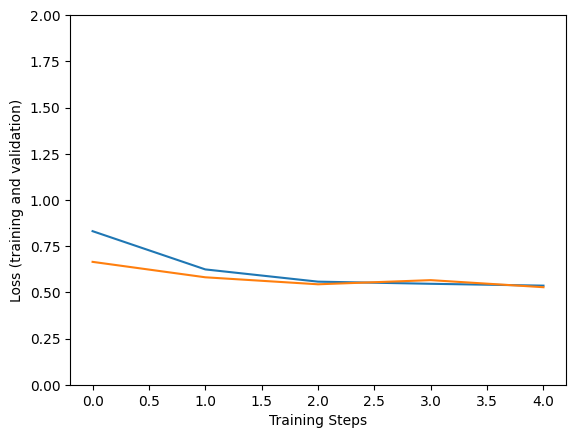

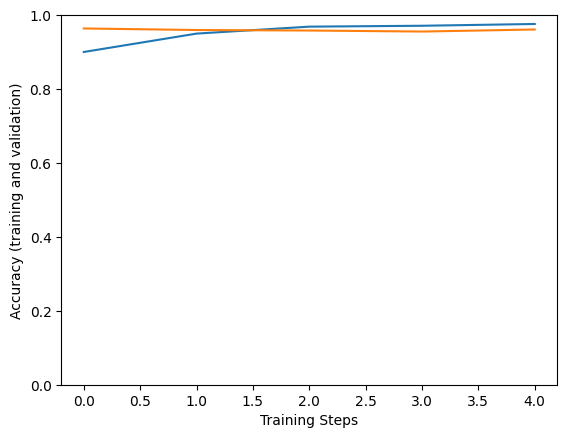

In [10]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

Try out the model on an image from the validation data:

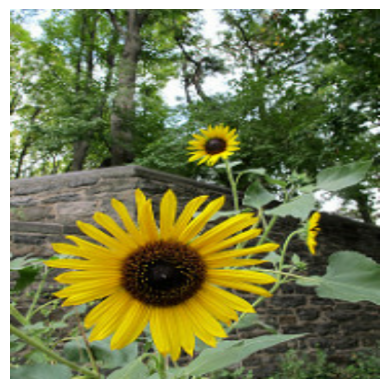

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 4s 4s/step


True label: sunflowers
Predicted label: sunflowers


In [11]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

Finally, the trained model can be saved for deployment to TF Serving or TFLite (on mobile) as follows.

In [12]:
saved_model_path = f"/tmp/saved_flowers_model_{model_name}"
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: /tmp/saved_flowers_model_efficientnetv2-xl-21k/assets


INFO:tensorflow:Assets written to: /tmp/saved_flowers_model_efficientnetv2-xl-21k/assets


## Optional: Deployment to TensorFlow Lite

[TensorFlow Lite](https://www.tensorflow.org/lite) lets you deploy TensorFlow models to mobile and IoT devices. The code below shows how to convert the trained model to TFLite and apply post-training tools from the [TensorFlow Model Optimization Toolkit](https://www.tensorflow.org/model_optimization). Finally, it runs it in the TFLite Interpreter to examine the resulting quality

  * Converting without optimization provides the same results as before (up to roundoff error).
  * Converting with optimization without any data quantizes the model weights to 8 bits, but inference still uses floating-point computation for the neural network activations. This reduces model size almost by a factor of 4 and improves CPU latency on mobile devices.
  * On top, computation of the neural network activations can be quantized to 8-bit integers as well if a small reference dataset is provided to calibrate the quantization range. On a mobile device, this accelerates inference further and makes it possible to run on accelerators like Edge TPU.

In [13]:
#@title Optimization settings
optimize_lite_model = False  #@param {type:"boolean"}
#@markdown Setting a value greater than zero enables quantization of neural network activations. A few dozen is already a useful amount.
num_calibration_examples = 60  #@param {type:"slider", min:0, max:1000, step:1}
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_ds for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open(f"/tmp/lite_flowers_model_{model_name}.tflite", "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

2023-12-07 14:45:33.895024: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-07 14:45:33.895075: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 879, Total Ops 2180, % non-converted = 40.32 %
 * 879 ARITH ops

- arith.constant:  879 occurrences  (f32: 878, i32: 1)



  (f32: 94)
  (f32: 358)
  (f32: 80)
  (f32: 1)
  (f32: 342)
  (f32: 81)
  (f32: 342)


Wrote TFLite model of 826217852 bytes.


In [14]:
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TFLite Interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [15]:
#@markdown For rapid experimentation, start with a moderate number of examples.
num_eval_examples = 50  #@param {type:"slider", min:0, max:700}
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_ds
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TFLite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TFLite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


TFLite model agrees with original model on 50 of 50 examples (100%).
TFLite model is accurate on 50 of 50 examples (100%).
